# Библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, mannwhitneyu, pearsonr, spearmanr, kendalltau, chi2_contingency
from sklearn.model_selection import train_test_split
import os
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_score, recall_score, RocCurveDisplay, roc_auc_score, f1_score, accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

# Функции

In [1]:
def histplot_boxplot_describe(feature_data, bins='auto'):
    """
    Функция строит гистограмму и boxplot, а также возвращает описание для заданного признака.
    
    :param feature_data: признак, для которого будет строиться гистограмма, boxplot и возвращает описание
    :param bins: Количество bins для гистограммы
    :return: Описание для заданного признака
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=feature_data, bins=bins, kde=True, color='orange')
    plt.title(f'Гистограмма признака {feature_data.name}')
    plt.xlabel(feature_data.name)
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=feature_data, data=df, color='orange')
    plt.title(f'Boxplot признака {feature_data.name}')
    plt.ylabel(feature_data.name)

    plt.show()

    stat, pvalue = shapiro(feature_data)

    print('Статистика теста Шапиро–Уилка: ', stat)
    print('p-значение теста Шапиро–Уилка: ', pvalue)

    if pvalue > 0.05:
        print(f'Принимаем нулевую гипотезу. Признак {feature_data.name}, вероятно, ИМЕЕТ нормальное распределение.')
    else:
        print(f'Отвергаем нулевую гипотезу. Признак {feature_data.name}, вероятно, НЕ ИМЕЕТ нормальное распределение.')

    return feature_data.describe()

In [3]:
def tests_for_groups(feature_data):
    """
    Функция для проведения статистических тестов между группами здоровых и с метаболическим синдромом 
    по указанному признаку.
    
    :param feature_data: Признак для анализа
    :return: None
    """

    colors = ['blue', 'red']

    figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
    sns.histplot(data=df, x=feature_data, hue=df['MetabolicSyndrome'], palette=colors, ax=axes[0])
    axes[0].grid(alpha=0.4)
    sns.boxplot(data=df, x='MetabolicSyndrome', y=feature_data, palette=colors, ax=axes[1])
    axes[1].set_xlabel('MetabolicSyndrome')
    axes[1].grid(alpha=0.4)
    figure.suptitle(f'Распределение {feature_data.name}: Здоровые и с метаболическим синдромом', fontsize=15)
    plt.tight_layout(pad=1)
    plt.show()

    target = df.groupby('MetabolicSyndrome')
    healthy = target.get_group(0)
    ms_ind = target.get_group(1)
    display(target[feature_data.name].describe())

    healthy = healthy[~healthy[feature_data.name].isna()]
    ms_ind = ms_ind[~ms_ind[feature_data.name].isna()]

    print('---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- ')

    stat, pvalue = shapiro(healthy[feature_data.name])
    print('Здоровые люди:')
    print('Статистика теста Шапиро–Уилка: ', stat)
    print('p-значение теста Шапиро–Уилка: ', pvalue)
    if pvalue > 0.05:
        print(f'Признак {feature_data.name} в группе здоровых людей, вероятно, ИМЕЕТ нормальное распределение.')
    else:
        print(f'Признак {feature_data.name} в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.')

    stat, pvalue = shapiro(ms_ind[feature_data.name])
    print('\nЛюди с метаболическим синдромом:')
    print('Статистика теста Шапиро–Уилка: ', stat)
    print('p-значение теста Шапиро–Уилка: ', pvalue)
    if pvalue > 0.05:
        print(f'Признак {feature_data.name} в группе с метаболическим синдромом, вероятно, ИМЕЕТ нормальное распределение.')
    else:
        print(f'Признак {feature_data.name} в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.')

    print('\n---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- ')
    stat, pvalue = levene(healthy[feature_data.name], ms_ind[feature_data.name])
    print(f'Статистика теста Левена: {stat}\np-значение теста Левена: {pvalue}')
    if pvalue > 0.05:
        print(f'Дисперсии {feature_data.name} между группами здоровых и с метаболическим синдромом, вероятно, ОДНОРОДНЫ.')
    else:
        print(f'Дисперсии {feature_data.name} между группами здоровых и с метаболическим синдромом, вероятно, НЕОДНОРОДНЫ.')

    print('\n---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- ')
    res = mannwhitneyu(healthy[feature_data.name], ms_ind[feature_data.name])
    test_stat = res[0]
    pvalue = res[1]

    print('Статистика теста Манна-Уитни: ', test_stat)
    print('p-значение теста Манна-Уитни: ', pvalue)

    if pvalue > 0.05:
        print(f'Принимаем нулевую гипотезу. Веротяно, не существует статистически значимой разницы в {feature_data.name} между двумя группами. Это указывает на НЕЗАВИСИМОСТЬ между {feature_data.name} и метаболическим синдромом.')
    else:
        print(f'Отвергаем нулевую гипотезу. Веротяно, существует статистически значимая разница в {feature_data.name} между двумя группами. Это указывает на ЗАВИСИМОСТЬ между {feature_data.name} и метаболическим синдромом.')

In [4]:
def correlations(feature_one, feature_two):
    """
    Функция для рассчёта корреляции между бинарным и непрерывным признаком
    
    :param feature_one: Бинарный признак
    :param feature_two: Непрерывный признак
    
    :return: None
    """

    corr_pearson, p_value_pearson = pearsonr(feature_one, feature_two)
    print("Корреляция Пирсона:", corr_pearson)
    if p_value_pearson > 0.05:
        print("Принимаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически НЕ ЗНАЧИМА.")
    else:
        print("Отвергаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически ЗНАЧИМА.")

    corr_spearman, p_value_spearman = spearmanr(feature_one, feature_two)
    print("\nКорреляция Спирмена:", corr_spearman)
    if p_value_spearman > 0.05:
        print("Принимаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически НЕ ЗНАЧИМА.")
    else:
        print("Отвергаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически ЗНАЧИМА.")

    corr_kendall, p_value_kendall = kendalltau(feature_one, feature_two)
    print("\nКорреляция Кендалла:", corr_kendall)
    if p_value_kendall > 0.05:
        print("Принимаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически НЕ ЗНАЧИМА.")
    else:
        print("Отвергаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически ЗНАЧИМА.")

In [5]:
def kramers_coefficient(binary_feature, categorical_feature):
    """
    Функция для расчета корреляции между бинарным признаком и категориальным признаком
    
    :param binary_feature: Бинарный признак
    :param categorical_feature: Категориальный признак
    :return: None
    """
    
    confusion_matrix = pd.crosstab(binary_feature, categorical_feature)
    chi2, p, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum()
    r, c = confusion_matrix.shape
    cramer_v = np.sqrt(chi2 / (n * min(r-1, c-1)))
    
    print("Коэффициент Крамера:", cramer_v)
    if p > 0.05:
        print("Принимаем нулевую гипотезу. Вероятно, статистической значимости НЕТ.")
    else:
        print("Отвергаем нулевую гипотезу. Вероятно, статистическая значимость ЕСТЬ.")

In [6]:
def fill_missing_with_mean(data):
    """
    Функция для заполнения пропусков средними значениями
    
    :param data: Данные
    :return: Данные, где пропуски заполнены средним значением
    """

    means = data.mean()
    df_filled = data.fillna(means)
    
    return df_filled

In [7]:
def catplot_describe(feature_data):
    """
    Функция строит countplot и возвращает описание для заданного категориального признака.
    
    :param feature_data: категориальный признак, для которого будет строиться countplot и возвращает описание
    :return: Описание для заданного категориального признака
    """
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=feature_data, palette='Set2')
    plt.title(f'Countplot для {feature_data.name}')
    plt.xlabel(feature_data.name)
    plt.ylabel('Частота')
    plt.show()

    return feature_data.describe()

In [8]:
def calculate_statistics_with_plots(feature_data):
    """
    Функция вычисляет статистику по заданному признаку и строит графики.
    
    :param feature_data: Признак, по которому нужно вычислить статистику.
    :return: None
    """
    counts_feature = df.groupby([feature_data, 'MetabolicSyndrome']).size().unstack(fill_value=0)
    percentages_feature = df.groupby(feature_data)['MetabolicSyndrome'].value_counts(normalize=True).mul(100).unstack(fill_value=0).round(0)
    combined_table = counts_feature.merge(percentages_feature, left_index=True, right_index=True, suffixes=('_count', '_percent'))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    counts_feature.plot(kind='bar', ax=ax[0], rot=0)
    ax[0].set_title('Количество')
    percentages_feature.plot(kind='bar', ax=ax[1], rot=0)
    ax[1].set_title('Проценты')
    plt.tight_layout()
    plt.show()

    print("Количество и проценты:")
    display(combined_table)

In [9]:
def chi_square_analysis(feature_one, feature_two):
    """
    Выполняет анализ хи-квадрат для двух категориальных признаков.
    
    :param feature_one: Первый категориальный признак
    :param feature_two: Второй категориальный признак
    :return: None
    """

    contingency_table = pd.crosstab(feature_one, feature_two)
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print("Хи-квадрат статистика:", chi2)
    print("p-value:", p_value)

    if p_value > 0.05:
        print("Принимаем нулевую гипотезу. Веротяно, НЕТ статистически значимой связи между", feature_one.name, "и", feature_two.name)
    else:
        print("Отвергаем нулевую гипотезу. Веротяно, ЕСТЬ статистически значимая связь между", feature_one.name, "и", feature_two.name)

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes):
    """
     Построение матрицы ошибок для оценки производительности модели классификации.
    
    :param y_true: Фактические метки классов для тестового набора данных.
    :param y_pred: Предсказанные метки классов для тестового набора данных.
    :param classes: Список имен классов. Должен быть в том же порядке, в котором классы представлены в матрице ошибок.
    :return: None
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Предсказанные классы')
    plt.ylabel('Фактические классы')
    plt.title('Матрица ошибок')
    plt.show()

In [11]:
def boxplot_cat(categorical_data, continuous_data):
    """
    Функция строит boxplot для двух признаков.
    
    :param categorical_data: Признак, содержащий категориальные данные.
    :param continuous_data: Признак, содержащий непрерывные данные.
    :return: None
    """

    plt.figure(figsize=(8, 6))
    sns.boxplot(x=categorical_data, y=continuous_data)
    plt.title(f'Boxplot для {categorical_data.name} и {continuous_data.name}')
    plt.xlabel(categorical_data.name)
    plt.ylabel(continuous_data.name)
    plt.show()

# Разведочный анализ данных (EDA)

In [12]:
df = pd.read_csv('Metabolic Syndrome.csv')
df

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,71901,48,Female,Married,1000.0,Other,NaN,59.7,0,22.11,5.8,152,57,107,0
2397,71904,30,Female,Single,2000.0,Asian,NaN,18.0,0,2.90,7.9,91,90,91,0
2398,71909,28,Male,Single,800.0,MexAmerican,100.8,29.4,0,2.78,6.2,99,47,84,0
2399,71911,27,Male,Married,8200.0,MexAmerican,106.6,31.3,0,4.15,6.2,100,41,124,1


In [13]:
df.shape

(2401, 15)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 281.5+ KB


In [15]:
df.duplicated().sum()

0

In [16]:
df.isna().sum() 

seqn                   0
Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

## seqn

seqn (int64): Порядковый идентификационный номер

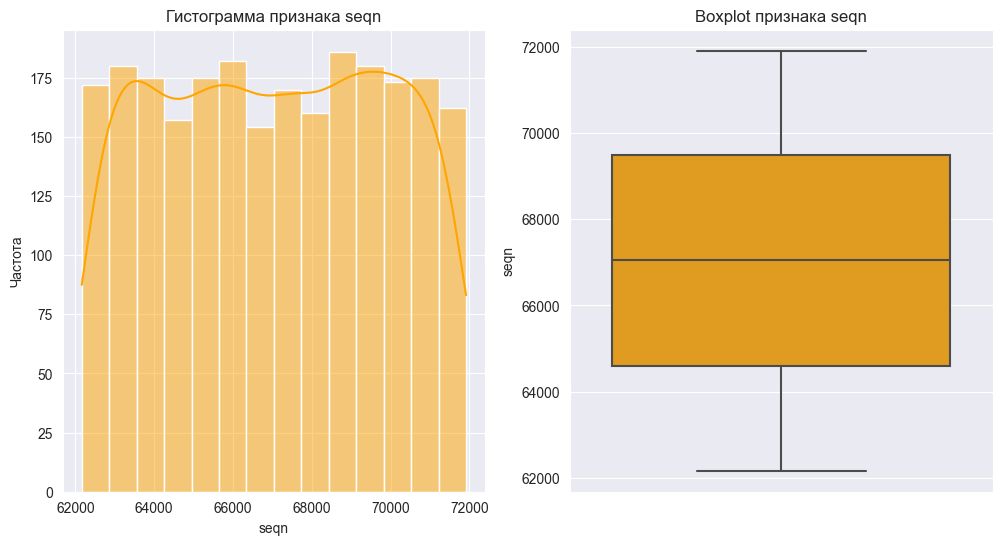

Статистика теста Шапиро–Уилка:  0.9540054798126221
p-значение теста Шапиро–Уилка:  7.41014257240622e-27
Отвергаем нулевую гипотезу. Признак seqn, вероятно, НЕ ИМЕЕТ нормальное распределение.


count     2401.000000
mean     67030.674302
std       2823.565114
min      62161.000000
25%      64591.000000
50%      67059.000000
75%      69495.000000
max      71915.000000
Name: seqn, dtype: float64

In [17]:
histplot_boxplot_describe(df['seqn'])

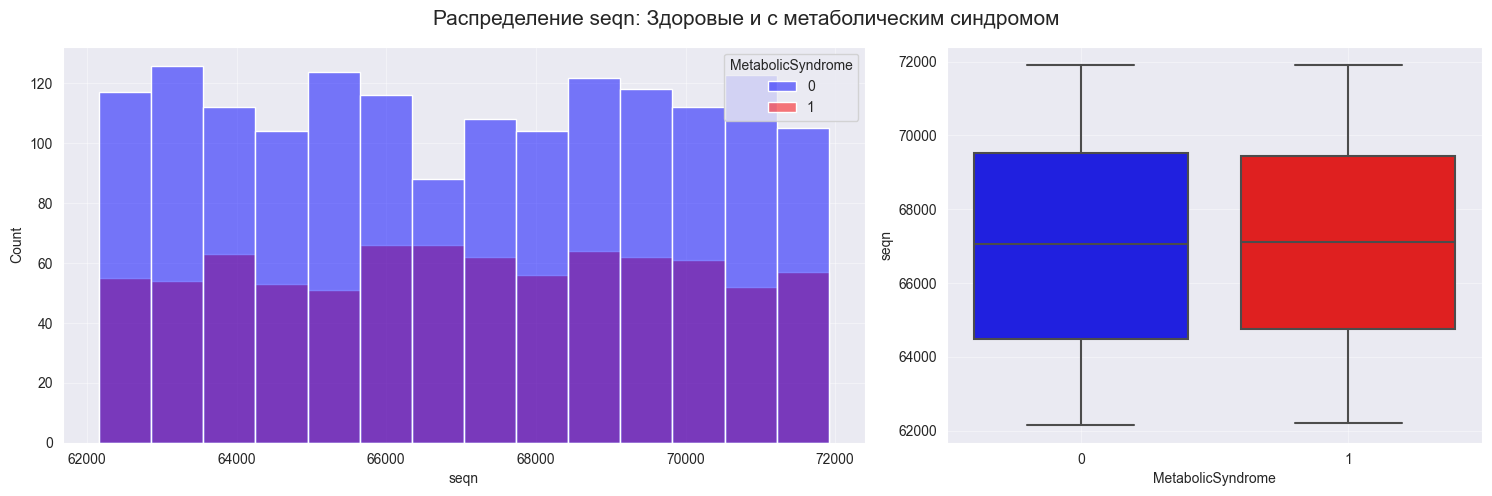

,count,mean,std,min,25%,50%,75%,max
MetabolicSyndrome,,,,,,,,
0,1579.0,67007.526916,2848.756780,62161.0,64479.5,67058.0,69517.00,71909.0
1,822.0,67075.138686,2775.710621,62199.0,64745.5,67118.0,69432.25,71915.0


---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- 
Здоровые люди:
Статистика теста Шапиро–Уилка:  0.9502558708190918
p-значение теста Шапиро–Уилка:  1.0335003665553622e-22
Признак seqn в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.

Люди с метаболическим синдромом:
Статистика теста Шапиро–Уилка:  0.9602736234664917
p-значение теста Шапиро–Уилка:  3.887768403108664e-14
Признак seqn в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- 
Статистика теста Левена: 2.759418591563902
p-значение теста Левена: 0.09681403550491502
Дисперсии seqn между группами здоровых и с метаболическим синдромом, вероятно, ОДНОРОДНЫ.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- 
Статистика теста Манна-Уитни:  640011.0
p-значение теста Манна-Уитни:  0.5783953376071975
Принимаем нулевую гипотезу. Веротяно, не существует статистически значимой разницы в seqn между двумя группами. Это указывает на

In [18]:
tests_for_groups(df['seqn'])

In [19]:
correlations(df['MetabolicSyndrome'], df['seqn'])

Корреляция Пирсона: 0.011364485354278883
Принимаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически НЕ ЗНАЧИМА.

Корреляция Спирмена: 0.011344427526091005
Принимаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически НЕ ЗНАЧИМА.

Корреляция Кендалла: 0.009264615009423927
Принимаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически НЕ ЗНАЧИМА.


Результат ожидаемый, ибо было бы странно, если порядковый номер влиял на наличие или отсутствие синдрома.

## Age

Age (int64): Возраст человека

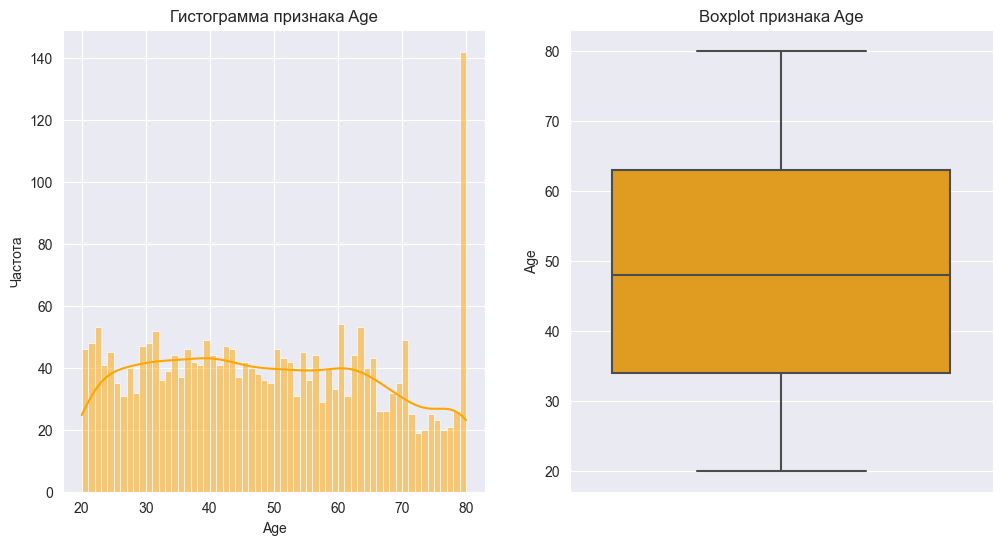

Статистика теста Шапиро–Уилка:  0.9574803113937378
p-значение теста Шапиро–Уилка:  6.321751335547185e-26
Отвергаем нулевую гипотезу. Признак Age, вероятно, НЕ ИМЕЕТ нормальное распределение.


count    2401.000000
mean       48.691795
std        17.632852
min        20.000000
25%        34.000000
50%        48.000000
75%        63.000000
max        80.000000
Name: Age, dtype: float64

In [20]:
histplot_boxplot_describe(df['Age'], 60)

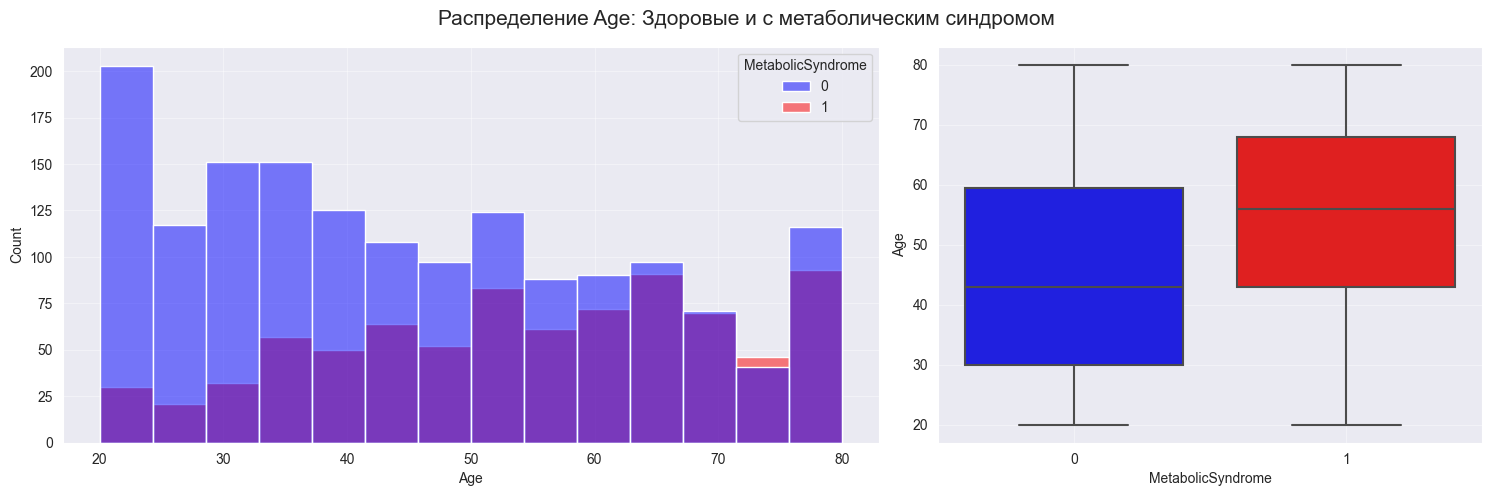

,count,mean,std,min,25%,50%,75%,max
MetabolicSyndrome,,,,,,,,
0,1579.0,45.529449,17.610585,20.0,30.0,43.0,59.5,80.0
1,822.0,54.766423,16.019520,20.0,43.0,56.0,68.0,80.0


---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- 
Здоровые люди:
Статистика теста Шапиро–Уилка:  0.945679247379303
p-значение теста Шапиро–Уилка:  1.1361531322122172e-23
Признак Age в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.

Люди с метаболическим синдромом:
Статистика теста Шапиро–Уилка:  0.9684383273124695
p-значение теста Шапиро–Уилка:  2.441871574734855e-12
Признак Age в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- 
Статистика теста Левена: 13.13165577817874
p-значение теста Левена: 0.000296382548152175
Дисперсии Age между группами здоровых и с метаболическим синдромом, вероятно, НЕОДНОРОДНЫ.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- 
Статистика теста Манна-Уитни:  449338.0
p-значение теста Манна-Уитни:  3.0426071534153445e-35
Отвергаем нулевую гипотезу. Веротяно, существует статистически значимая разница в Age между двумя группами. Это указывает на 

In [21]:
tests_for_groups(df['Age'])

In [22]:
correlations(df['MetabolicSyndrome'], df['Age'])

Корреляция Пирсона: 0.24861793067750643
Отвергаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Спирмена: 0.25286562716572114
Отвергаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Кендалла: 0.20836362251650623
Отвергаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически ЗНАЧИМА.


Исходя из данных, заметно, что при повышении возраста число заболевших увеличивается.

## Sex

Sex (object): Пол человека

Male - мужской
Female - женский

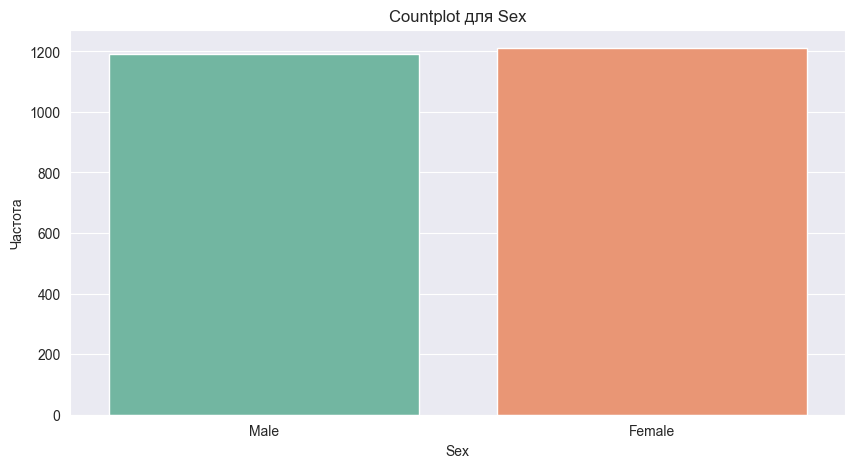

count       2401
unique         2
top       Female
freq        1211
Name: Sex, dtype: object

In [23]:
catplot_describe(df['Sex'])

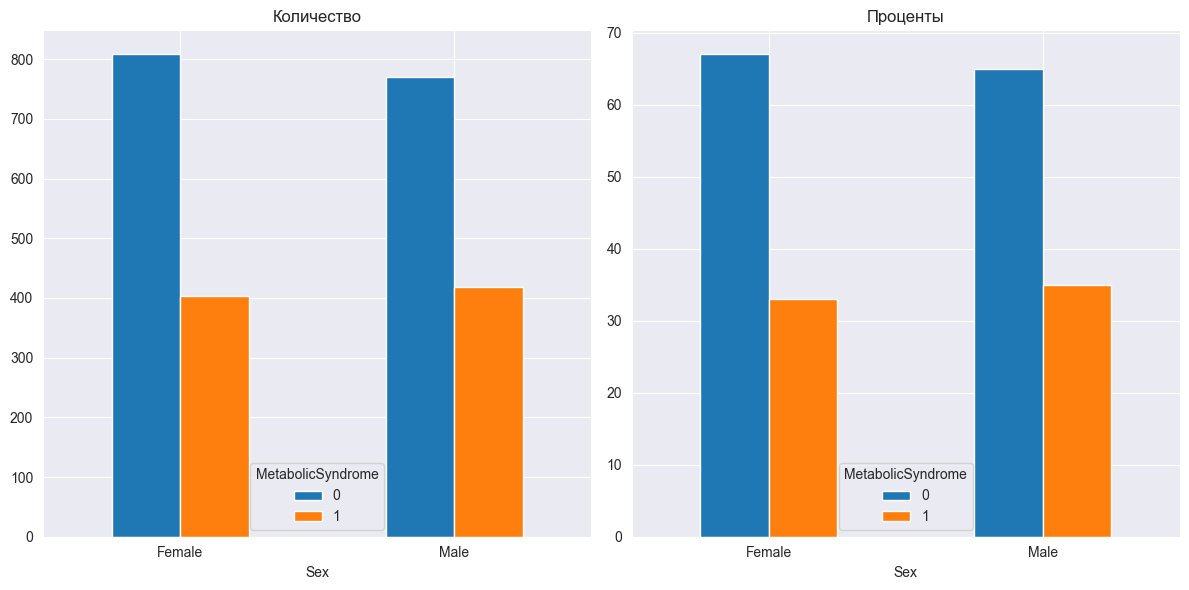

Количество и проценты:


MetabolicSyndrome,0_count,1_count,0_percent,1_percent
Sex,,,,
Female,808,403,67.0,33.0
Male,771,419,65.0,35.0


In [24]:
calculate_statistics_with_plots(df['Sex'])

In [25]:
chi_square_analysis(df['MetabolicSyndrome'], df['Sex'])

Хи-квадрат статистика: 0.9108914813100117
p-value: 0.3398779931081079
Принимаем нулевую гипотезу. Веротяно, НЕТ статистически значимой связи между MetabolicSyndrome и Sex


In [26]:
kramers_coefficient(df['MetabolicSyndrome'], df['Sex'])

Коэффициент Крамера: Sex
Female    0.027426
Male      0.027667
dtype: float64
Принимаем нулевую гипотезу. Вероятно, статистической значимости НЕТ.


Исходя из данных, можно предположить, что пол не влияет на наличие синдрома.

## Marital

Marital (object): Семейное положение человека

Divorced - Разведен(а)
Married - Женат(а)
Separated - Раздельно проживающий(ая)
Single - Не женат(а)
Widowed - Овдовевший(ая)
nan - Неизвестно

In [27]:
df['Marital'] = df['Marital'].astype(str)

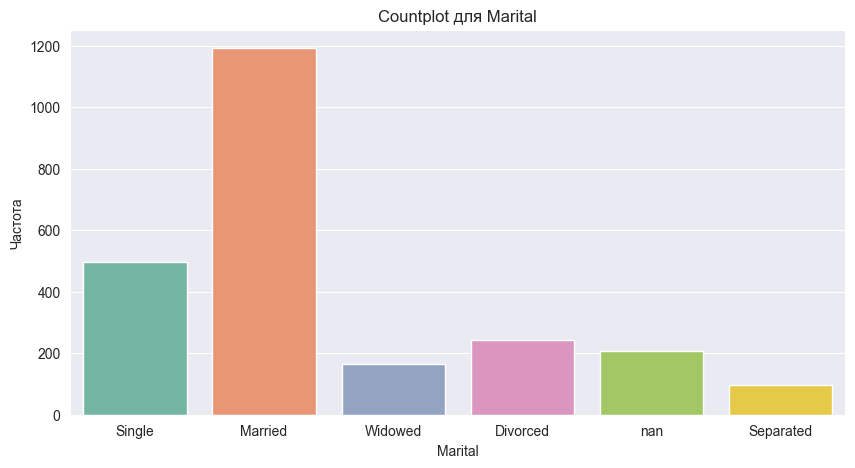

count        2401
unique          6
top       Married
freq         1192
Name: Marital, dtype: object

In [28]:
catplot_describe(df['Marital'])

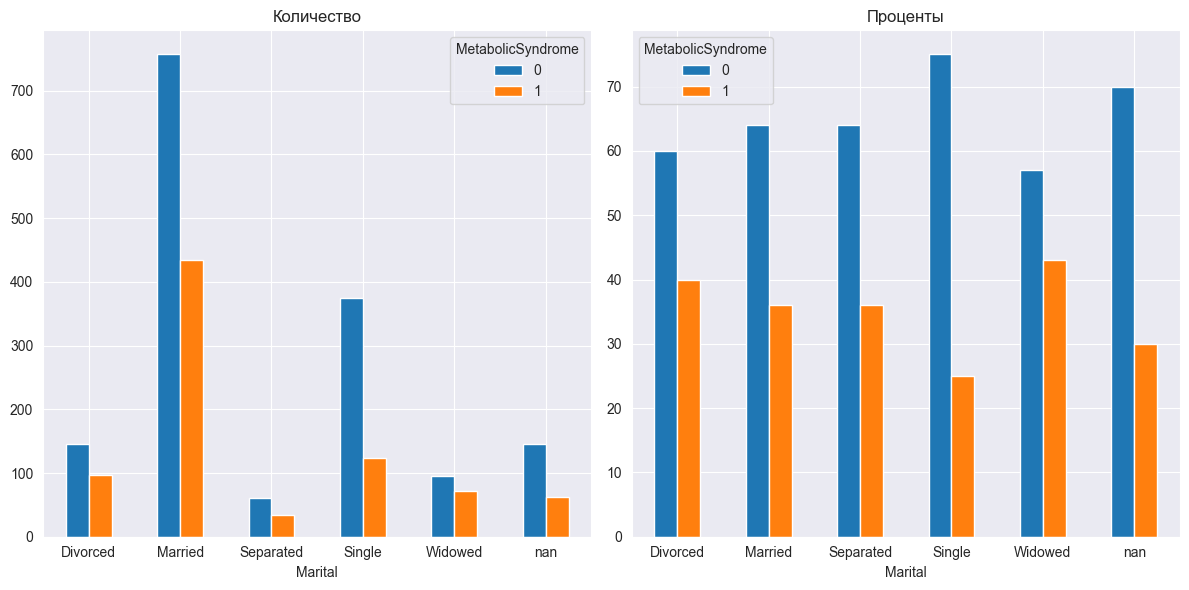

Количество и проценты:


MetabolicSyndrome,0_count,1_count,0_percent,1_percent
Marital,,,,
Divorced,145,97,60.0,40.0
Married,757,435,64.0,36.0
Separated,61,34,64.0,36.0
Single,375,123,75.0,25.0
Widowed,95,71,57.0,43.0
nan,146,62,70.0,30.0


In [29]:
calculate_statistics_with_plots(df['Marital'])

In [30]:
chi_square_analysis(df['MetabolicSyndrome'], df['Marital'])

Хи-квадрат статистика: 33.77502543567307
p-value: 2.639582032407282e-06
Отвергаем нулевую гипотезу. Веротяно, ЕСТЬ статистически значимая связь между MetabolicSyndrome и Marital


In [31]:
kramers_coefficient(df['MetabolicSyndrome'], df['Marital'])

Коэффициент Крамера: Marital
Divorced     0.373586
Married      0.168329
Separated    0.596260
Single       0.260425
Widowed      0.451070
nan          0.402964
dtype: float64
Отвергаем нулевую гипотезу. Вероятно, статистическая значимость ЕСТЬ.


Исходя из данных, можно предположить, что семейное положение оказывает какое-то влияние на наличие синдрома.

## Income

Income (float64): Уровень дохода

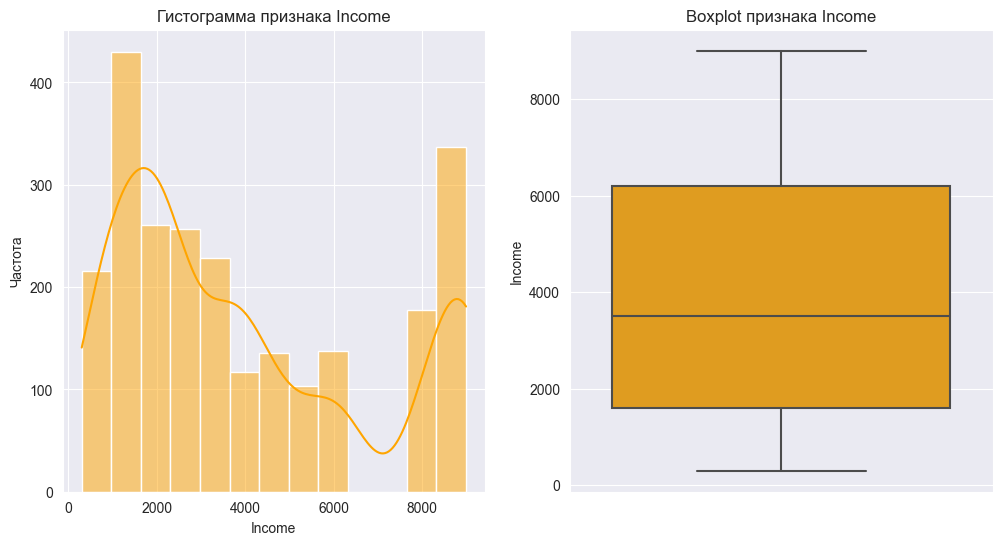

Статистика теста Шапиро–Уилка:  0.870668351650238
p-значение теста Шапиро–Уилка:  9.803343926569988e-41
Отвергаем нулевую гипотезу. Признак Income, вероятно, НЕ ИМЕЕТ нормальное распределение.


count    2401.000000
mean     4005.253940
std      2881.128031
min       300.000000
25%      1600.000000
50%      3500.000000
75%      6200.000000
max      9000.000000
Name: Income, dtype: float64

In [32]:
histplot_boxplot_describe(fill_missing_with_mean(df['Income']))

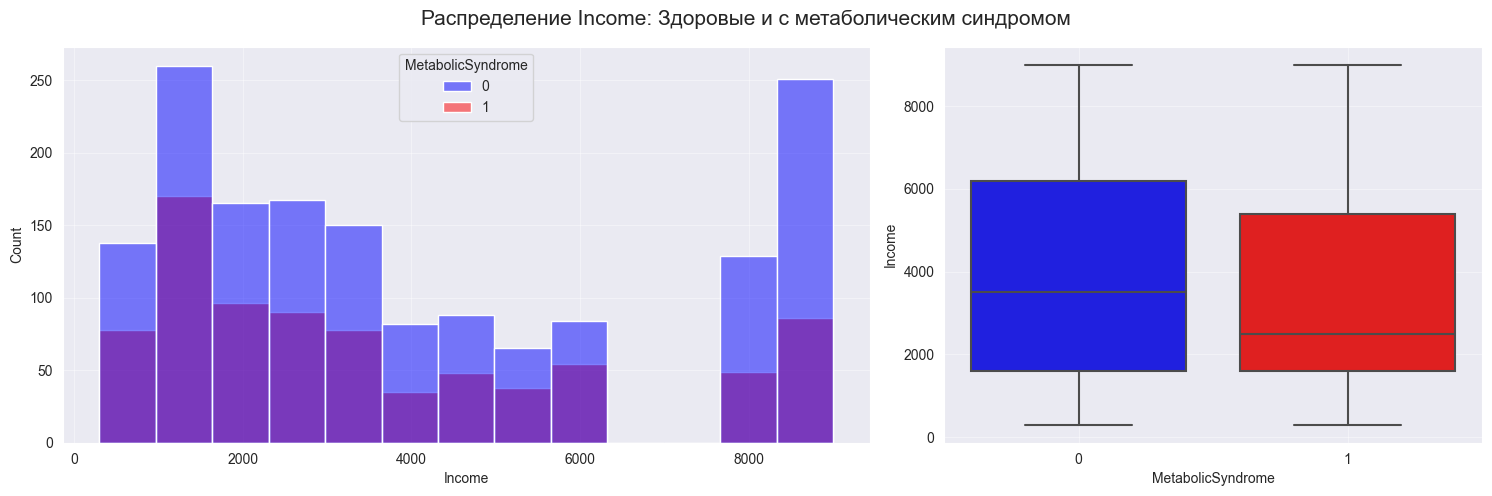

,count,mean,std,min,25%,50%,75%,max
MetabolicSyndrome,,,,,,,,
0,1497.0,4184.502338,3028.242777,300.0,1600.0,3500.0,8200.0,9000.0
1,787.0,3664.294790,2777.560640,300.0,1600.0,2500.0,5400.0,9000.0


---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- 
Здоровые люди:
Статистика теста Шапиро–Уилка:  0.858769953250885
p-значение теста Шапиро–Уилка:  1.1848119802624773e-34
Признак Income в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.

Люди с метаболическим синдромом:
Статистика теста Шапиро–Уилка:  0.8583217859268188
p-значение теста Шапиро–Уилка:  5.275142455496852e-26
Признак Income в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- 
Статистика теста Левена: 19.052639259666357
p-значение теста Левена: 1.3283249835526778e-05
Дисперсии Income между группами здоровых и с метаболическим синдромом, вероятно, НЕОДНОРОДНЫ.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- 
Статистика теста Манна-Уитни:  643519.5
p-значение теста Манна-Уитни:  0.0002604802879543902
Отвергаем нулевую гипотезу. Веротяно, существует статистически значимая разница в Income между двумя группами. Это

In [33]:
tests_for_groups(fill_missing_with_mean(df['Income']))

In [34]:
correlations(df['MetabolicSyndrome'], fill_missing_with_mean(df['Income']))

Корреляция Пирсона: -0.08176698980700392
Отвергаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Спирмена: -0.07572975786544883
Отвергаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Кендалла: -0.06430094281837194
Отвергаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически ЗНАЧИМА.


Исходя из данных, можно предположить, что доход оказывает какое-то влияние на наличие синдрома.

## Race

Race (object): Этническое или расовое происхождение человека

Asian - Азиат(ка)
Black - Афроамериканец(ка)
Hispanic - Испанец(ка)
MexAmerican - Мексиканец(ка)
Other - Другой
White - Белый

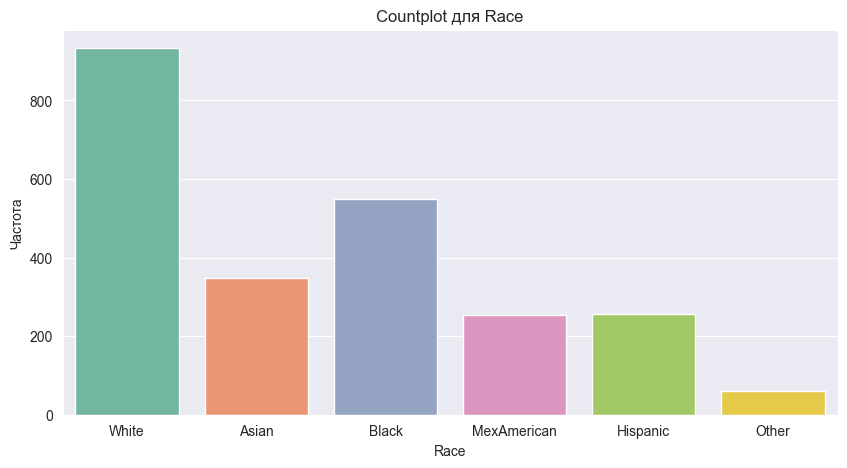

count      2401
unique        6
top       White
freq        933
Name: Race, dtype: object

In [35]:
catplot_describe(df['Race'])

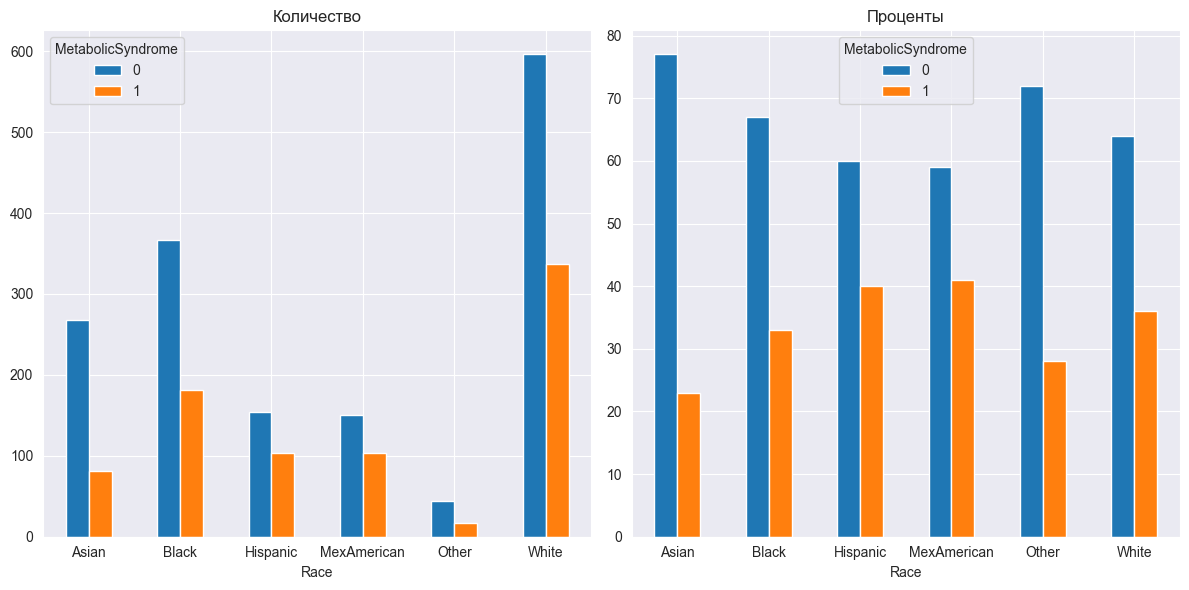

Количество и проценты:


MetabolicSyndrome,0_count,1_count,0_percent,1_percent
Race,,,,
Asian,268,81,77.0,23.0
Black,367,181,67.0,33.0
Hispanic,154,103,60.0,40.0
MexAmerican,150,103,59.0,41.0
Other,44,17,72.0,28.0
White,596,337,64.0,36.0


In [36]:
calculate_statistics_with_plots(df['Race'])

In [37]:
chi_square_analysis(df['MetabolicSyndrome'], df['Race'])

Хи-квадрат статистика: 30.37876529143362
p-value: 1.2420912078884288e-05
Отвергаем нулевую гипотезу. Веротяно, ЕСТЬ статистически значимая связь между MetabolicSyndrome и Race


In [38]:
kramers_coefficient(df['MetabolicSyndrome'], df['Race'])

Коэффициент Крамера: Race
Asian          0.295034
Black          0.235448
Hispanic       0.343810
MexAmerican    0.346517
Other          0.705700
White          0.180445
dtype: float64
Отвергаем нулевую гипотезу. Вероятно, статистическая значимость ЕСТЬ.


Исходя из данных, можно предположить, что расса оказывает какое-то влияние на наличие синдрома.

## WaistCirc

WaistCirc (float64): Измерение обхвата талии

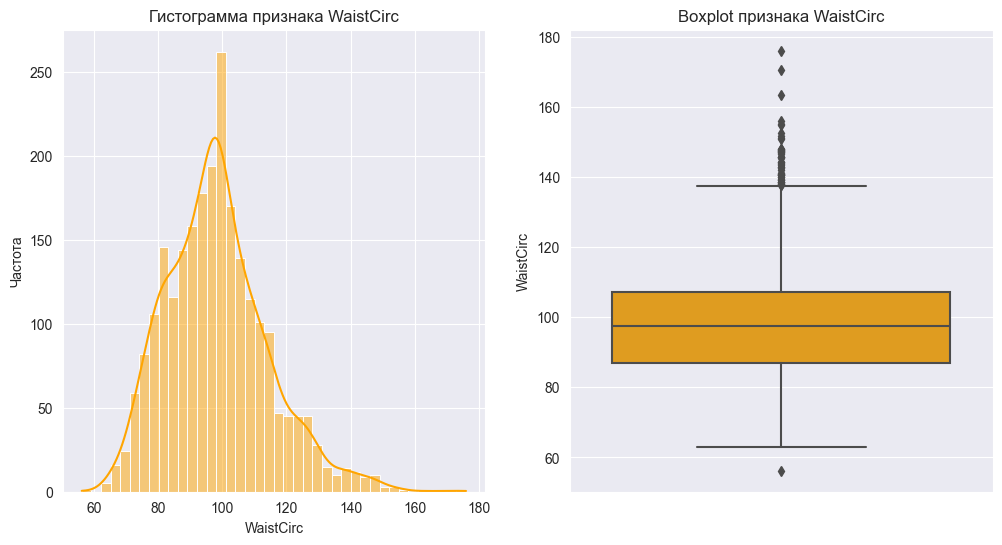

Статистика теста Шапиро–Уилка:  0.9763563871383667
p-значение теста Шапиро–Уилка:  1.605267668010121e-19
Отвергаем нулевую гипотезу. Признак WaistCirc, вероятно, НЕ ИМЕЕТ нормальное распределение.


count    2401.000000
mean       98.307254
std        15.962233
min        56.200000
25%        87.000000
50%        97.500000
75%       107.200000
max       176.000000
Name: WaistCirc, dtype: float64

In [39]:
histplot_boxplot_describe(fill_missing_with_mean(df['WaistCirc']))

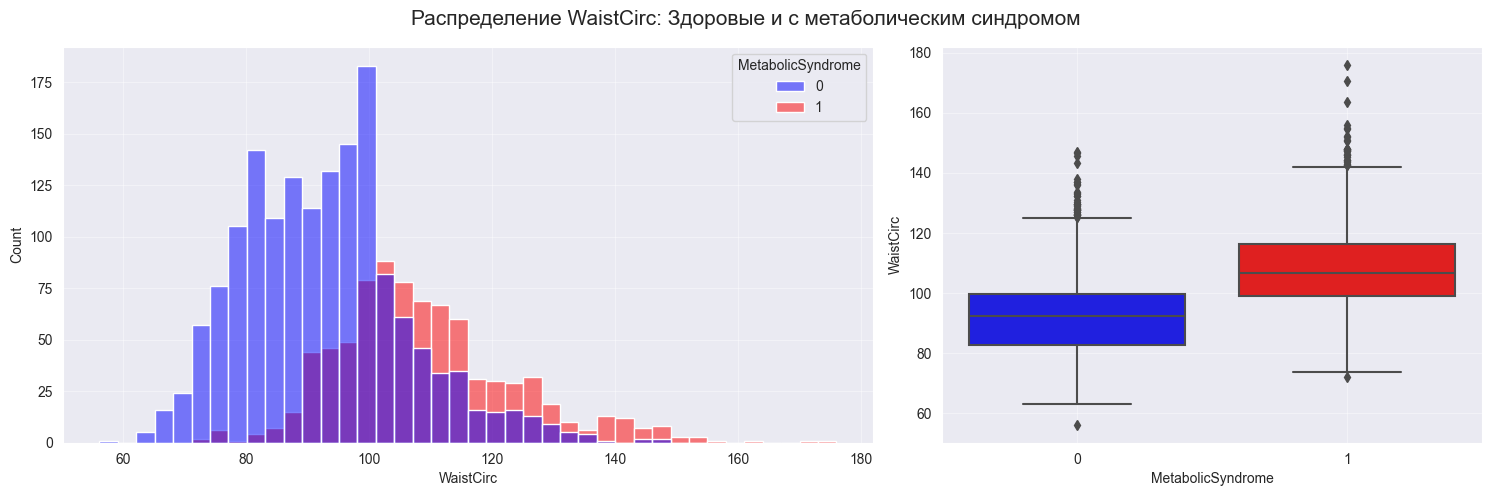

,count,mean,std,min,25%,50%,75%,max
MetabolicSyndrome,,,,,,,,
0,1510.0,92.401391,13.670630,56.2,82.300,91.60,100.000,147.0
1,806.0,109.371588,14.876469,72.0,99.825,107.15,116.775,176.0


---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- 
Здоровые люди:
Статистика теста Шапиро–Уилка:  0.9753586649894714
p-значение теста Шапиро–Уилка:  2.0611970789029266e-15
Признак WaistCirc в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.

Люди с метаболическим синдромом:
Статистика теста Шапиро–Уилка:  0.9642578363418579
p-значение теста Шапиро–Уилка:  3.899481377991204e-13
Признак WaistCirc в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- 
Статистика теста Левена: 1.7032097306384406
p-значение теста Левена: 0.19199850673343452
Дисперсии WaistCirc между группами здоровых и с метаболическим синдромом, вероятно, ОДНОРОДНЫ.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- 
Статистика теста Манна-Уитни:  229985.5
p-значение теста Манна-Уитни:  1.2437013469993842e-134
Отвергаем нулевую гипотезу. Веротяно, существует статистически значимая разница в WaistCirc между двумя гру

In [40]:
tests_for_groups(fill_missing_with_mean(df['WaistCirc']))

In [41]:
correlations(df['MetabolicSyndrome'], fill_missing_with_mean(df['WaistCirc']))

Корреляция Пирсона: 0.4904900181694939
Отвергаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Спирмена: 0.5056068156494914
Отвергаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Кендалла: 0.4135392871261319
Отвергаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически ЗНАЧИМА.


Исходя из данных, заметно, что в среднем у людей с обхватом больше 100, риск развития синдрома больше. 
Также заметны многие выбросы, как у людей без синдрома, так и у которых он имеется.

## BMI

BMI: Индекс массы тела - это показатель, который определяет соотношение между весом человека и его ростом.

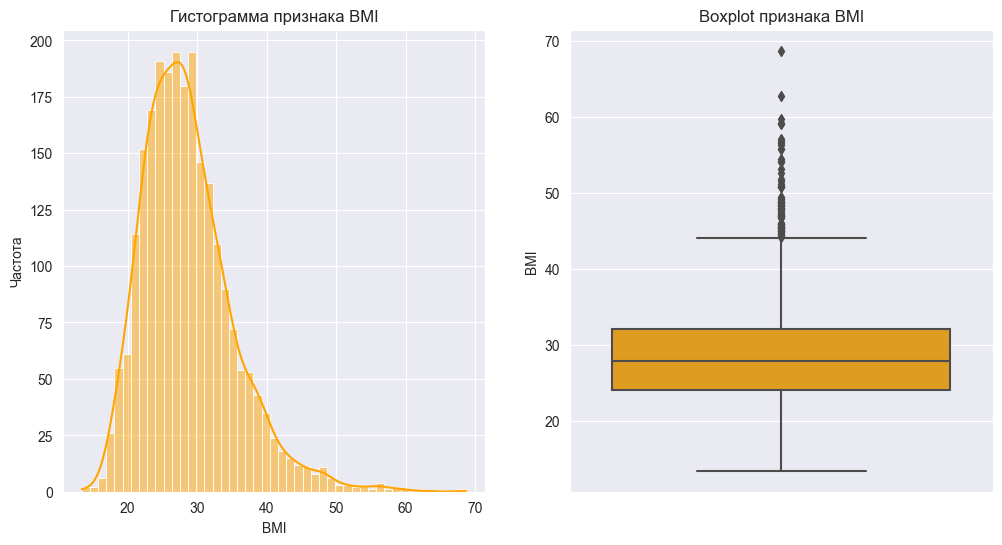

Статистика теста Шапиро–Уилка:  0.9414227604866028
p-значение теста Шапиро–Уилка:  7.8412259093635e-30
Отвергаем нулевую гипотезу. Признак BMI, вероятно, НЕ ИМЕЕТ нормальное распределение.


count    2401.000000
mean       28.702189
std         6.626057
min        13.400000
25%        24.000000
50%        27.800000
75%        32.000000
max        68.700000
Name: BMI, dtype: float64

In [42]:
histplot_boxplot_describe(fill_missing_with_mean(df['BMI']))

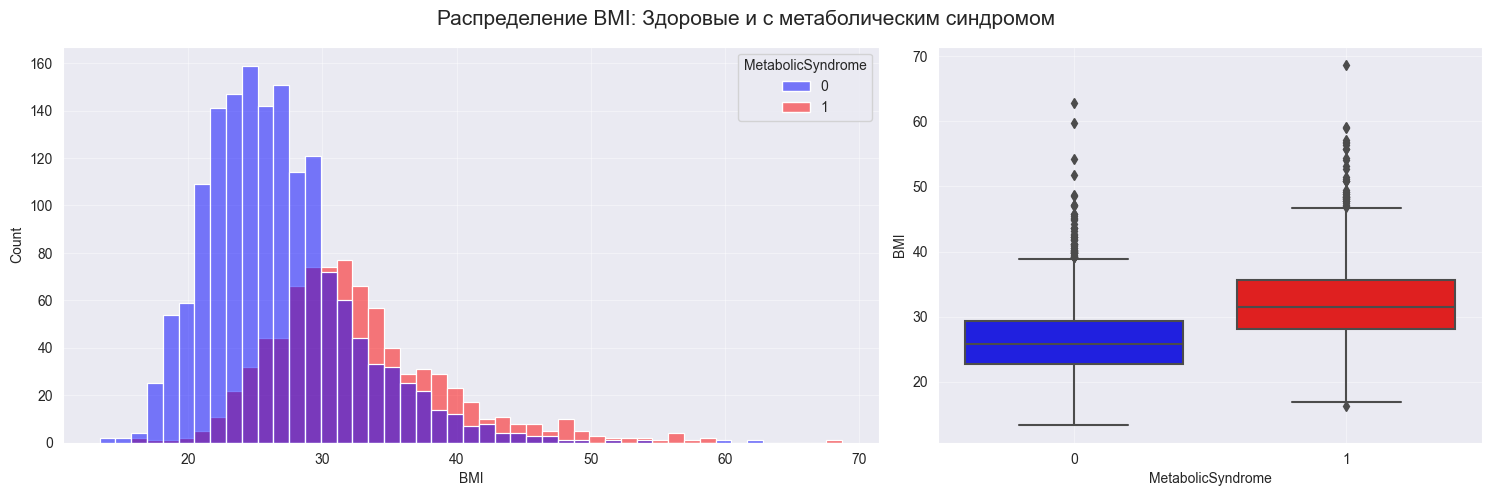

,count,mean,std,min,25%,50%,75%,max
MetabolicSyndrome,,,,,,,,
0,1558.0,26.624134,5.602682,13.4,22.8,25.8,29.3,62.8
1,817.0,32.664994,6.728165,16.2,28.1,31.7,35.7,68.7


---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- 
Здоровые люди:
Статистика теста Шапиро–Уилка:  0.93573397397995
p-значение теста Шапиро–Уилка:  2.1313761946813714e-25
Признак BMI в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.

Люди с метаболическим синдромом:
Статистика теста Шапиро–Уилка:  0.937049150466919
p-значение теста Шапиро–Уилка:  4.3858667041210064e-18
Признак BMI в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- 
Статистика теста Левена: 18.08449898022772
p-значение теста Левена: 2.1950030436109306e-05
Дисперсии BMI между группами здоровых и с метаболическим синдромом, вероятно, НЕОДНОРОДНЫ.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- 
Статистика теста Манна-Уитни:  282269.5
p-значение теста Манна-Уитни:  2.9702154618632965e-110
Отвергаем нулевую гипотезу. Веротяно, существует статистически значимая разница в BMI между двумя группами. Это указывает н

In [43]:
tests_for_groups(fill_missing_with_mean(df['BMI']))

In [44]:
correlations(df['MetabolicSyndrome'], fill_missing_with_mean(df['WaistCirc']))

Корреляция Пирсона: 0.4904900181694939
Отвергаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Спирмена: 0.5056068156494914
Отвергаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Кендалла: 0.4135392871261319
Отвергаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически ЗНАЧИМА.


Исходя из данных, заметно, что в среднем у людей с BMI больше 30, риск развития синдрома больше. 
Также заметны многие выбросы, как у людей без синдрома, так и у которых он имеется.

## Albuminuria 

Albuminuria (int64): Измерение, связанное с содержанием альбумина в моче

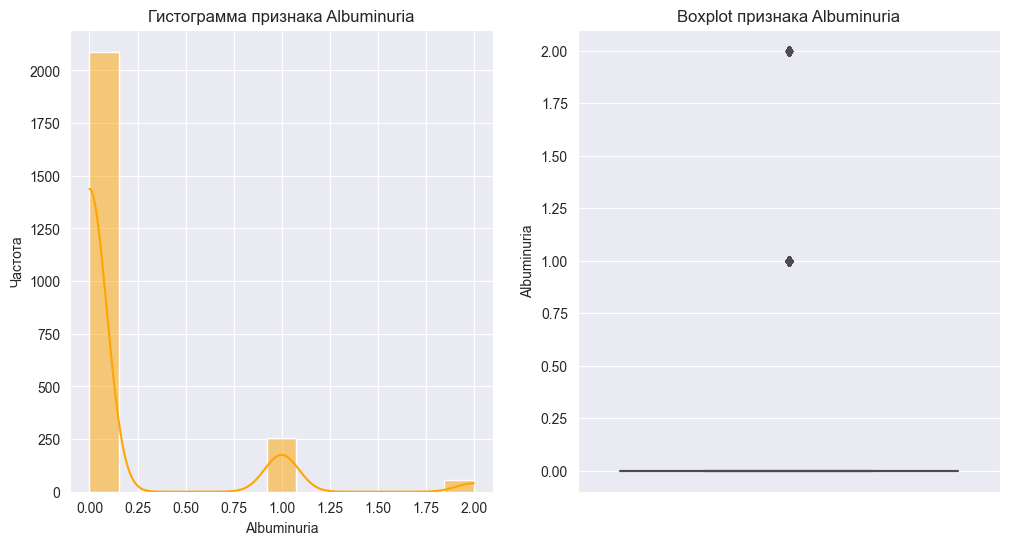

Статистика теста Шапиро–Уилка:  0.40273231267929077
p-значение теста Шапиро–Уилка:  0.0
Отвергаем нулевую гипотезу. Признак Albuminuria, вероятно, НЕ ИМЕЕТ нормальное распределение.


count    2401.000000
mean        0.154102
std         0.422780
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: Albuminuria, dtype: float64

In [45]:
histplot_boxplot_describe(df['Albuminuria'])

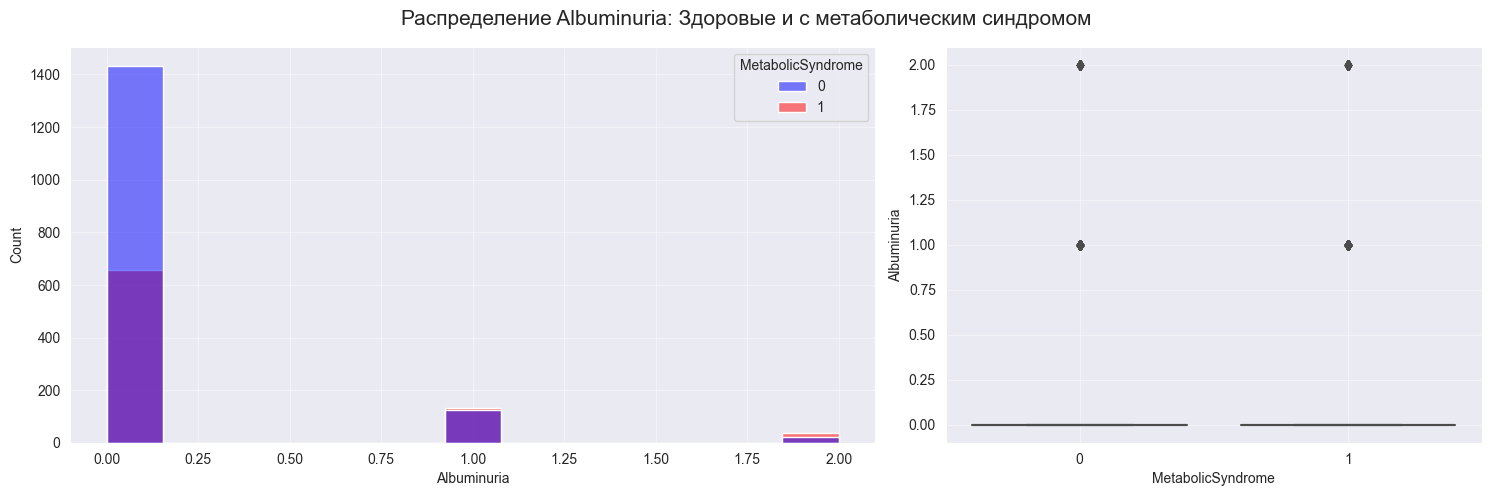

,count,mean,std,min,25%,50%,75%,max
MetabolicSyndrome,,,,,,,,
0,1579.0,0.105763,0.350029,0.0,0.0,0.0,0.0,2.0
1,822.0,0.246959,0.523349,0.0,0.0,0.0,0.0,2.0


---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- 
Здоровые люди:
Статистика теста Шапиро–Уилка:  0.3278379440307617
p-значение теста Шапиро–Уилка:  0.0
Признак Albuminuria в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.

Люди с метаболическим синдромом:
Статистика теста Шапиро–Уилка:  0.5148563981056213
p-значение теста Шапиро–Уилка:  1.500790655291879e-42
Признак Albuminuria в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- 
Статистика теста Левена: 61.822213787435196
p-значение теста Левена: 5.631549083319708e-15
Дисперсии Albuminuria между группами здоровых и с метаболическим синдромом, вероятно, НЕОДНОРОДНЫ.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- 
Статистика теста Манна-Уитни:  575944.5
p-значение теста Манна-Уитни:  7.994175671991424e-15
Отвергаем нулевую гипотезу. Веротяно, существует статистически значимая разница в Albuminuria между двумя группами. Эт

In [46]:
tests_for_groups(df['Albuminuria'])

In [47]:
df['Albuminuria'].unique()

array([0, 1, 2], dtype=int64)

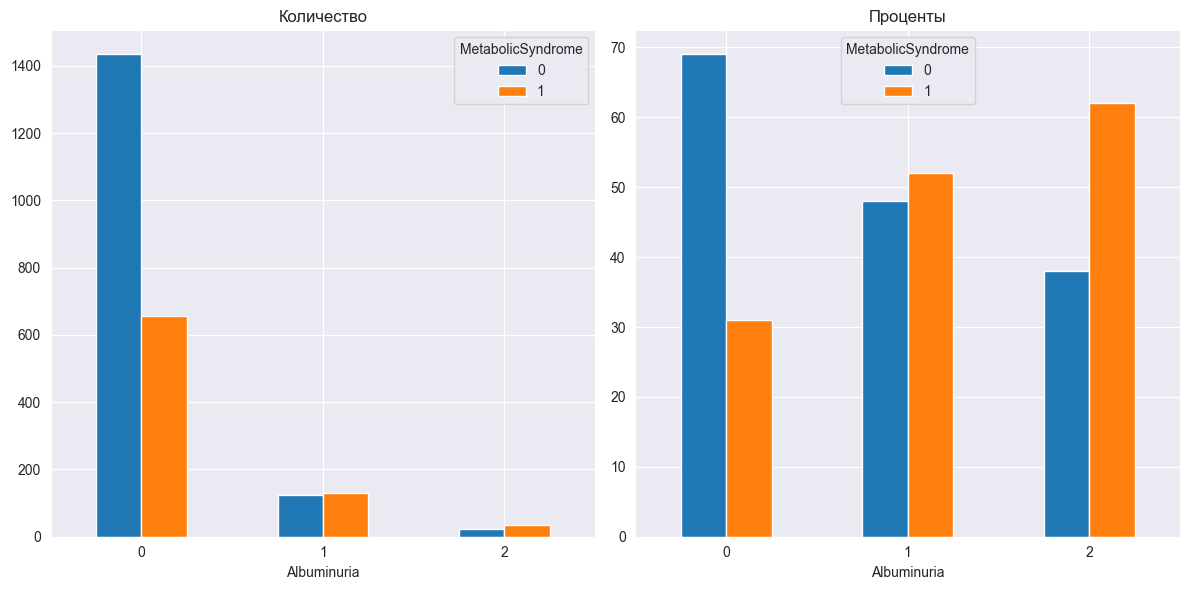

Количество и проценты:


MetabolicSyndrome,0_count,1_count,0_percent,1_percent
Albuminuria,,,,
0,1434,655,69.0,31.0
1,123,131,48.0,52.0
2,22,36,38.0,62.0


In [48]:
calculate_statistics_with_plots(df['Albuminuria'])

In [49]:
correlations(df['MetabolicSyndrome'], df['Albuminuria'])

Корреляция Пирсона: 0.15850105492218636
Отвергаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Спирмена: 0.15855802603215327
Отвергаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Кендалла: 0.15702598886923863
Отвергаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически ЗНАЧИМА.


Исходя из данных, можно предположить, что при увеличении количества альбумина, вероятность наличия синдрома больше.

## UrAlbCr

UrAlbCr (float64): Соотношение альбумина и креатинина в моче

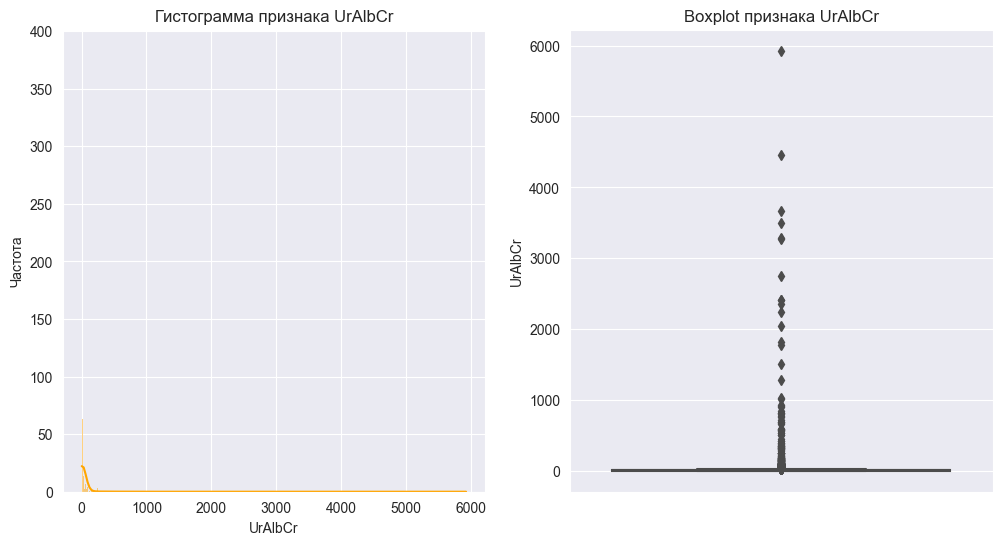

Статистика теста Шапиро–Уилка:  0.1251862645149231
p-значение теста Шапиро–Уилка:  0.0
Отвергаем нулевую гипотезу. Признак UrAlbCr, вероятно, НЕ ИМЕЕТ нормальное распределение.


count    2401.000000
mean       43.626131
std       258.272829
min         1.400000
25%         4.450000
50%         7.070000
75%        13.690000
max      5928.000000
Name: UrAlbCr, dtype: float64

In [50]:
histplot_boxplot_describe(df['UrAlbCr'])

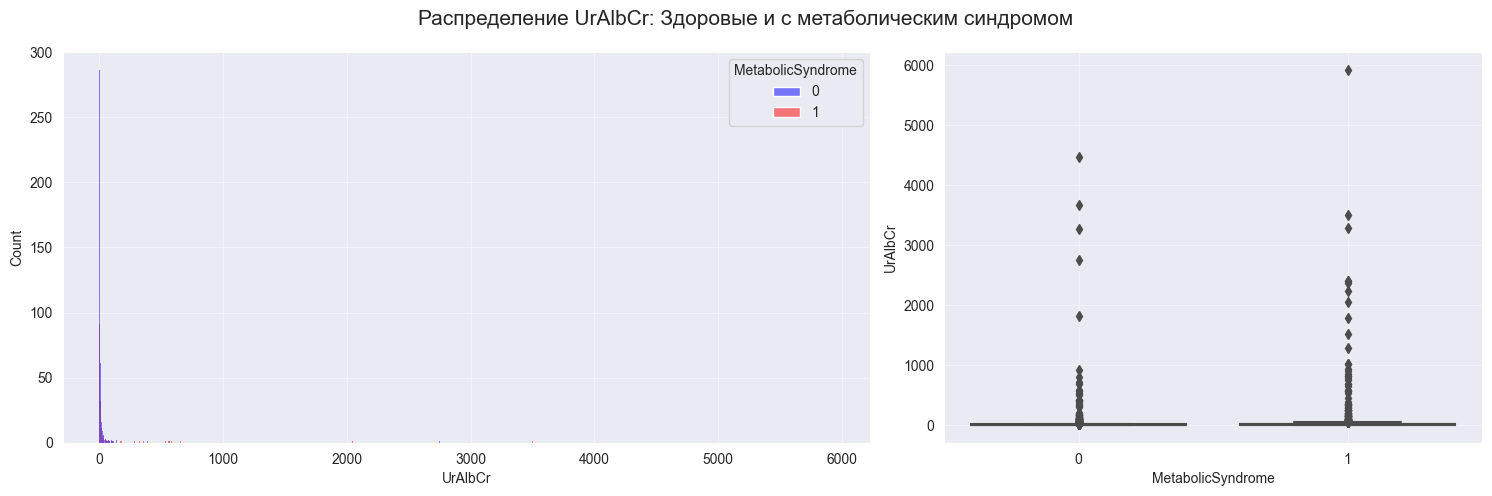

,count,mean,std,min,25%,50%,75%,max
MetabolicSyndrome,,,,,,,,
0,1579.0,27.758569,194.339406,1.40,4.1900,6.310,11.2500,4462.81
1,822.0,74.106521,347.836207,1.41,5.2025,9.145,22.7125,5928.00


---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- 
Здоровые люди:
Статистика теста Шапиро–Уилка:  0.08507013320922852
p-значение теста Шапиро–Уилка:  0.0
Признак UrAlbCr в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.

Люди с метаболическим синдромом:
Статистика теста Шапиро–Уилка:  0.18705588579177856
p-значение теста Шапиро–Уилка:  0.0
Признак UrAlbCr в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- 
Статистика теста Левена: 16.71896856405526
p-значение теста Левена: 4.477271114193059e-05
Дисперсии UrAlbCr между группами здоровых и с метаболическим синдромом, вероятно, НЕОДНОРОДНЫ.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- 
Статистика теста Манна-Уитни:  498632.5
p-значение теста Манна-Уитни:  1.0894016513844644e-20
Отвергаем нулевую гипотезу. Веротяно, существует статистически значимая разница в UrAlbCr между двумя группами. Это указывает на ЗАВИСИМОСТЬ между

In [51]:
tests_for_groups(df['UrAlbCr'])

In [52]:
correlations(df['MetabolicSyndrome'], df['UrAlbCr'])

Корреляция Пирсона: 0.08516812802658877
Отвергаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Спирмена: 0.19038662139822912
Отвергаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Кендалла: 0.15553997462748073
Отвергаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически ЗНАЧИМА.


Исходя из данных, заметно, что чем больше соотношение альбумина и креатинина в моче, тем риск развития синдрома больше. 
Также заметны многие выбросы, как у людей без синдрома, так и у которых он имеется.

## UricAcid

UricAcid (float64): Уровень мочевой кислоты в крови

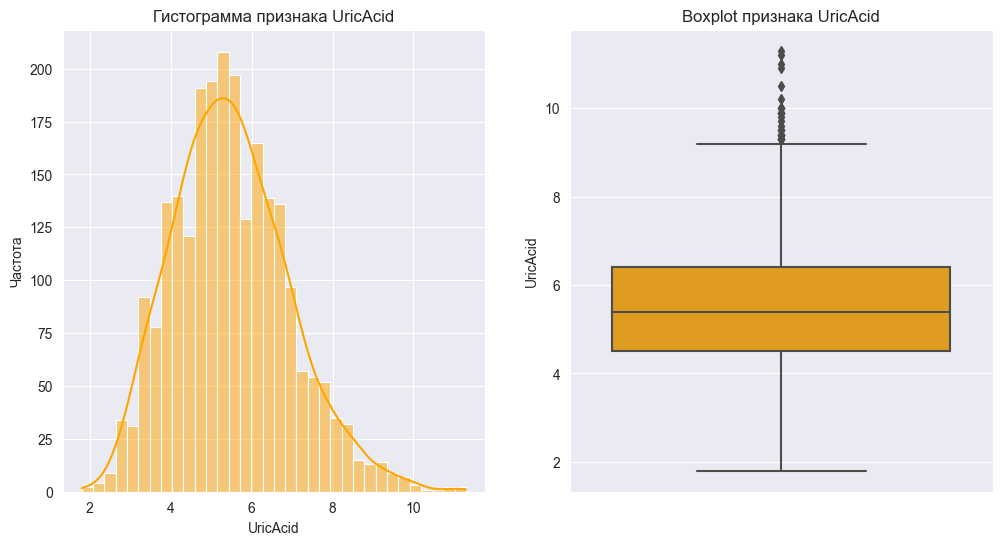

Статистика теста Шапиро–Уилка:  0.9864941835403442
p-значение теста Шапиро–Уилка:  2.5884747497555496e-14
Отвергаем нулевую гипотезу. Признак UricAcid, вероятно, НЕ ИМЕЕТ нормальное распределение.


count    2401.000000
mean        5.489046
std         1.439358
min         1.800000
25%         4.500000
50%         5.400000
75%         6.400000
max        11.300000
Name: UricAcid, dtype: float64

In [53]:
histplot_boxplot_describe(df['UricAcid'])

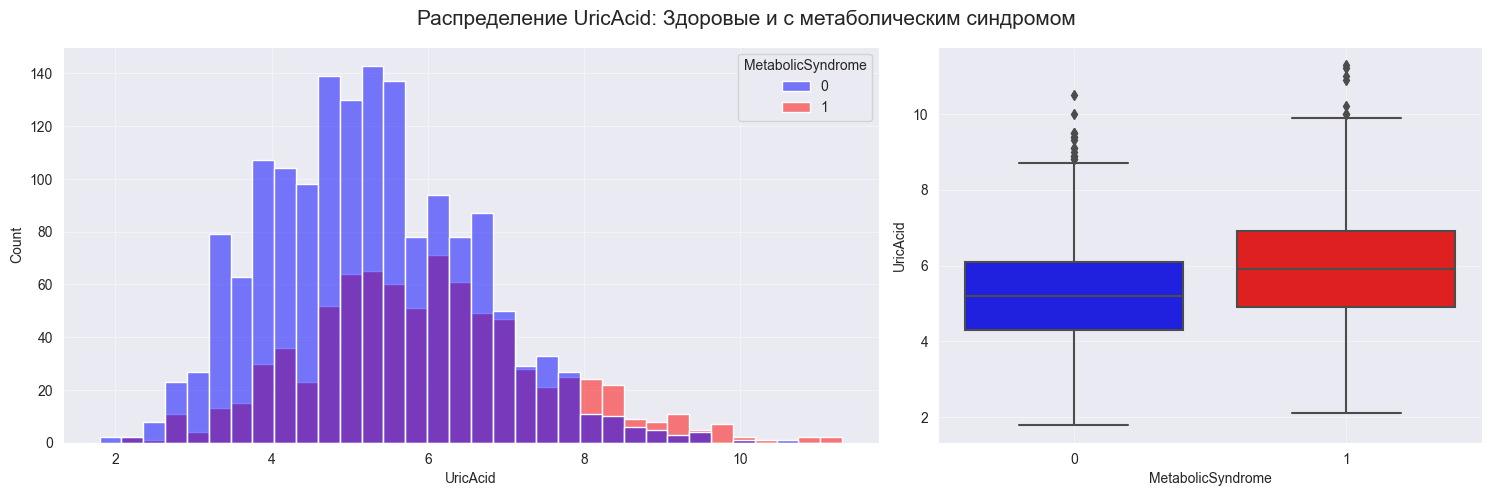

,count,mean,std,min,25%,50%,75%,max
MetabolicSyndrome,,,,,,,,
0,1579.0,5.233186,1.322248,1.8,4.3,5.2,6.1,10.5
1,822.0,5.980535,1.525819,2.1,4.9,5.9,6.9,11.3


---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- 
Здоровые люди:
Статистика теста Шапиро–Уилка:  0.9893776178359985
p-значение теста Шапиро–Уилка:  2.5245070478518983e-09
Признак UricAcid в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.

Люди с метаболическим синдромом:
Статистика теста Шапиро–Уилка:  0.989201009273529
p-значение теста Шапиро–Уилка:  9.580430742062163e-06
Признак UricAcid в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- 
Статистика теста Левена: 14.27311164458438
p-значение теста Левена: 0.00016195532488024914
Дисперсии UricAcid между группами здоровых и с метаболическим синдромом, вероятно, НЕОДНОРОДНЫ.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- 
Статистика теста Манна-Уитни:  463353.0
p-значение теста Манна-Уитни:  1.064695545748377e-30
Отвергаем нулевую гипотезу. Веротяно, существует статистически значимая разница в UricAcid между двумя группа

In [54]:
tests_for_groups(df['UricAcid'])

In [55]:
correlations(df['MetabolicSyndrome'], df['UricAcid'])

Корреляция Пирсона: 0.24642251813434196
Отвергаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Спирмена: 0.23512067264368644
Отвергаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Кендалла: 0.19390781496065715
Отвергаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически ЗНАЧИМА.


Исходя из данных, заметно, что чем больше уровень мочевой кислоты в крови, тем риск развития синдрома больше. 
Также заметны многие выбросы, как у людей без синдрома, так и у которых он имеется.

## BloodGlucose

BloodGlucose (int64): Уровень глюкозы в крови

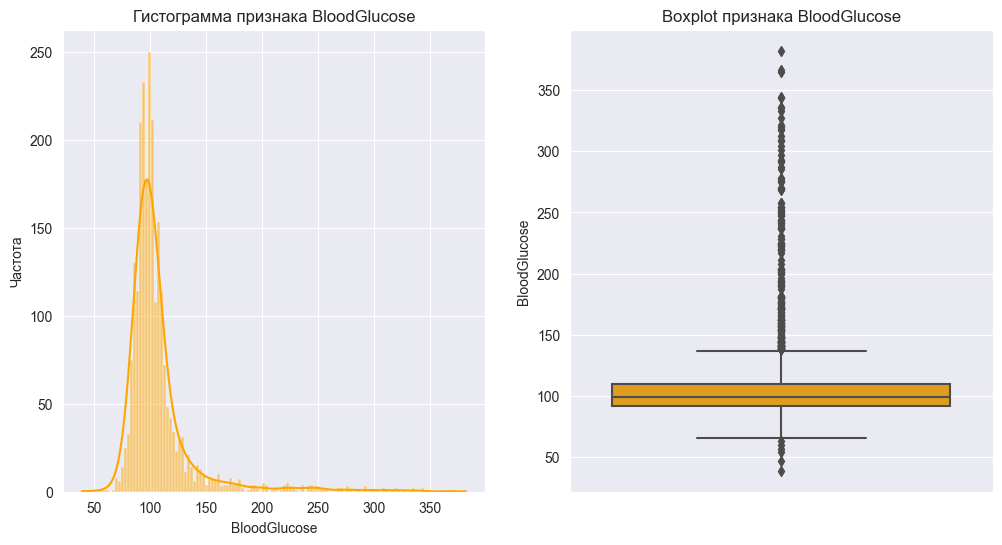

Статистика теста Шапиро–Уилка:  0.6012430787086487
p-значение теста Шапиро–Уилка:  0.0
Отвергаем нулевую гипотезу. Признак BloodGlucose, вероятно, НЕ ИМЕЕТ нормальное распределение.


count    2401.000000
mean      108.247813
std        34.820657
min        39.000000
25%        92.000000
50%        99.000000
75%       110.000000
max       382.000000
Name: BloodGlucose, dtype: float64

In [56]:
histplot_boxplot_describe(df['BloodGlucose'])

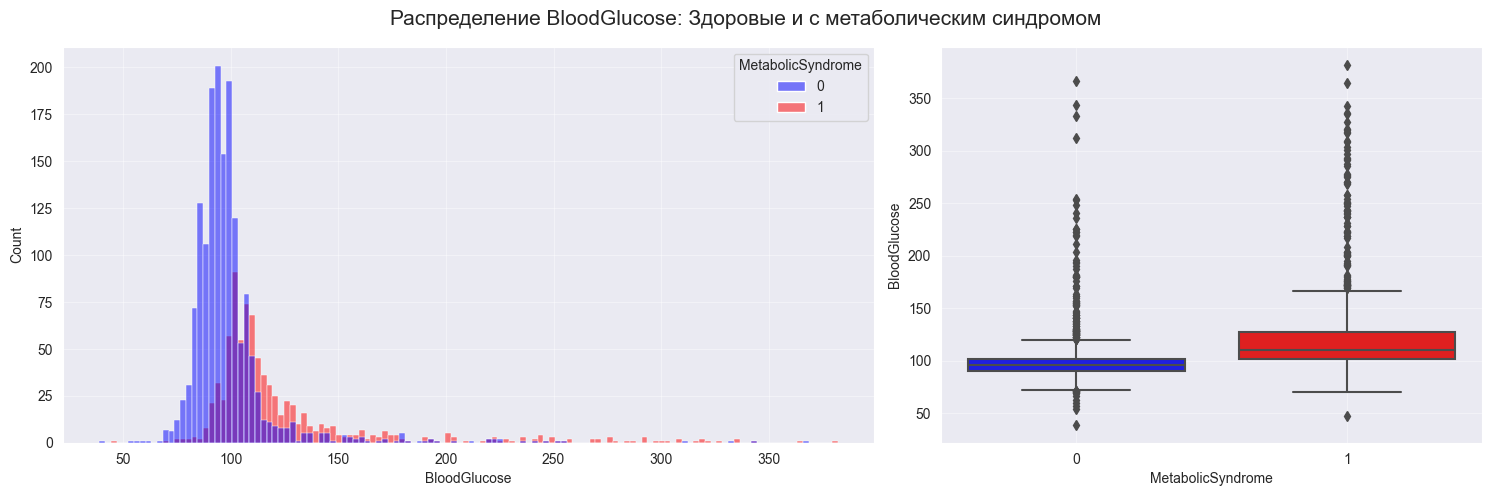

,count,mean,std,min,25%,50%,75%,max
MetabolicSyndrome,,,,,,,,
0,1579.0,99.149462,22.650689,39.0,90.0,96.0,102.00,366.0
1,822.0,125.725061,45.752017,47.0,102.0,110.0,127.75,382.0


---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- 
Здоровые люди:
Статистика теста Шапиро–Уилка:  0.567388653755188
p-значение теста Шапиро–Уилка:  0.0
Признак BloodGlucose в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.

Люди с метаболическим синдромом:
Статистика теста Шапиро–Уилка:  0.6592769622802734
p-значение теста Шапиро–Уилка:  1.499796966524857e-37
Признак BloodGlucose в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- 
Статистика теста Левена: 120.34542941543738
p-значение теста Левена: 2.346602578075926e-27
Дисперсии BloodGlucose между группами здоровых и с метаболическим синдромом, вероятно, НЕОДНОРОДНЫ.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- 
Статистика теста Манна-Уитни:  235207.5
p-значение теста Манна-Уитни:  2.0667975040751024e-145
Отвергаем нулевую гипотезу. Веротяно, существует статистически значимая разница в BloodGlucose между двумя группам

In [57]:
tests_for_groups(df['BloodGlucose'])

In [58]:
correlations(df['MetabolicSyndrome'], df['BloodGlucose'])

Корреляция Пирсона: 0.36221912530244565
Отвергаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Спирмена: 0.5241474856382436
Отвергаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Кендалла: 0.43250092929741885
Отвергаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически ЗНАЧИМА.


Исходя из данных, заметно, что у людей с синдромом уровень глюкозы в крови выше, чем у людей без синдрома.
Также заметны многие выбросы, как у людей без синдрома, так и у которых он имеется.

## HDL

HDL (int64): Уровень холестерина липопротеинов высокой плотности ("хорошего" холестерина)

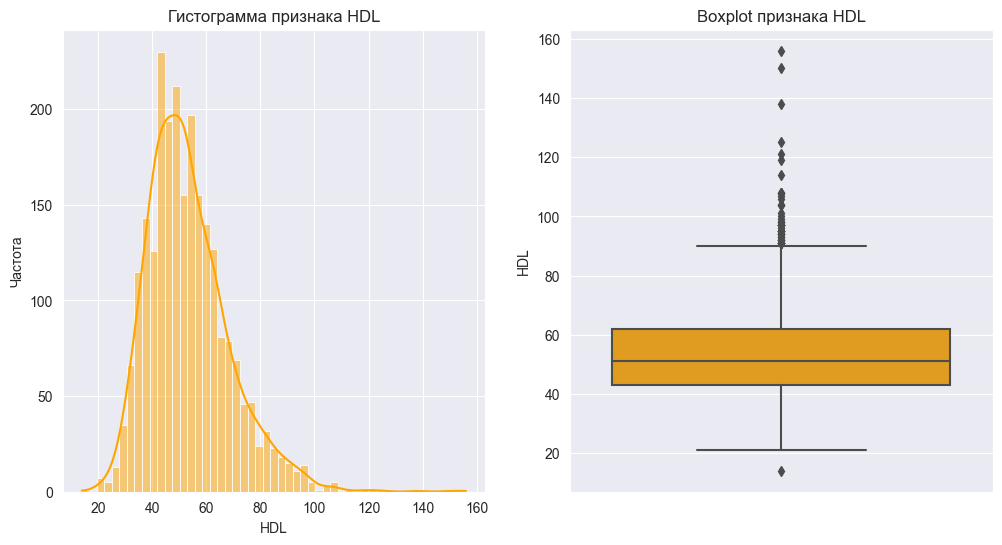

Статистика теста Шапиро–Уилка:  0.94695645570755
p-значение теста Шапиро–Уилка:  1.3656605531604617e-28
Отвергаем нулевую гипотезу. Признак HDL, вероятно, НЕ ИМЕЕТ нормальное распределение.


count    2401.000000
mean       53.369429
std        15.185537
min        14.000000
25%        43.000000
50%        51.000000
75%        62.000000
max       156.000000
Name: HDL, dtype: float64

In [59]:
histplot_boxplot_describe(df['HDL'])

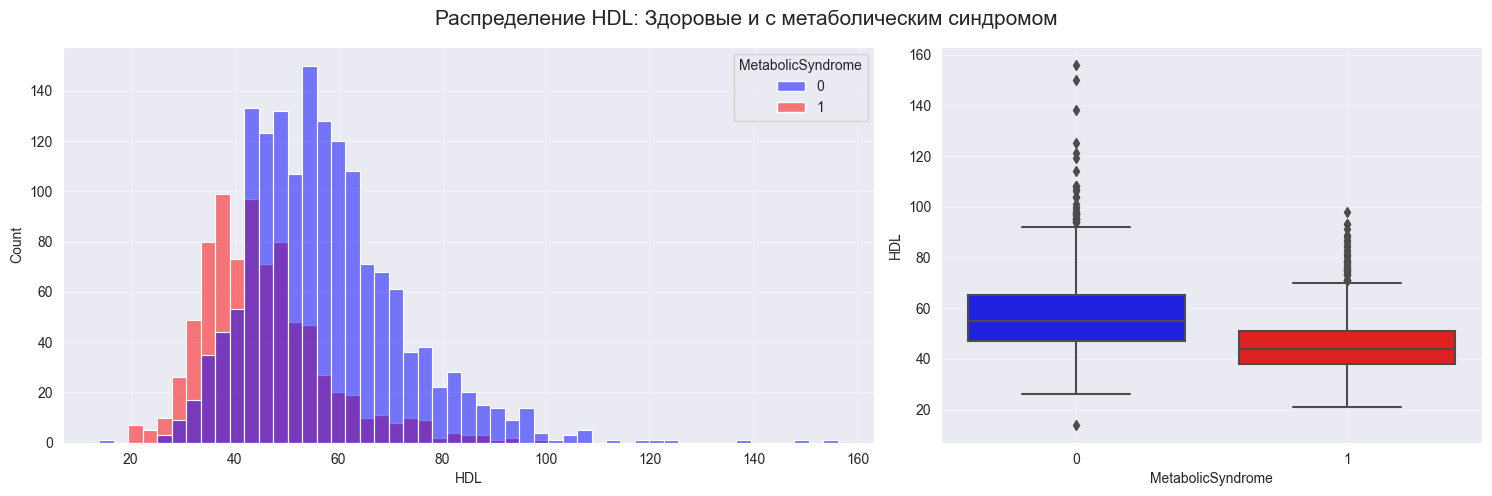

,count,mean,std,min,25%,50%,75%,max
MetabolicSyndrome,,,,,,,,
0,1579.0,57.437619,15.034784,14.0,47.0,55.0,65.0,156.0
1,822.0,45.554745,12.110486,21.0,38.0,44.0,51.0,98.0


---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- 
Здоровые люди:
Статистика теста Шапиро–Уилка:  0.9414497017860413
p-значение теста Шапиро–Уилка:  1.6667289863781104e-24
Признак HDL в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.

Люди с метаболическим синдромом:
Статистика теста Шапиро–Уилка:  0.9348866939544678
p-значение теста Шапиро–Уилка:  1.8475438804938334e-18
Признак HDL в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- 
Статистика теста Левена: 31.08802759516386
p-значение теста Левена: 2.7421879290086007e-08
Дисперсии HDL между группами здоровых и с метаболическим синдромом, вероятно, НЕОДНОРОДНЫ.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- 
Статистика теста Манна-Уитни:  975197.5
p-значение теста Манна-Уитни:  3.930307725255548e-91
Отвергаем нулевую гипотезу. Веротяно, существует статистически значимая разница в HDL между двумя группами. Это указывает 

In [60]:
tests_for_groups(df['HDL'])

In [61]:
correlations(df['MetabolicSyndrome'], df['HDL'])

Корреляция Пирсона: -0.37137836951944925
Отвергаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Спирмена: -0.4132503565483276
Отвергаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Кендалла: -0.3409876867462487
Отвергаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически ЗНАЧИМА.


Исходя из данных, заметно, что в среднем “хорошего” холестерина у людей без синдрома больше, чем у людей с синдромом.
Также заметны многие выбросы, как у людей без синдрома, так и у которых он имеется.

## Triglycerides 

Triglycerides (int64): Уровень триглицеридов в крови

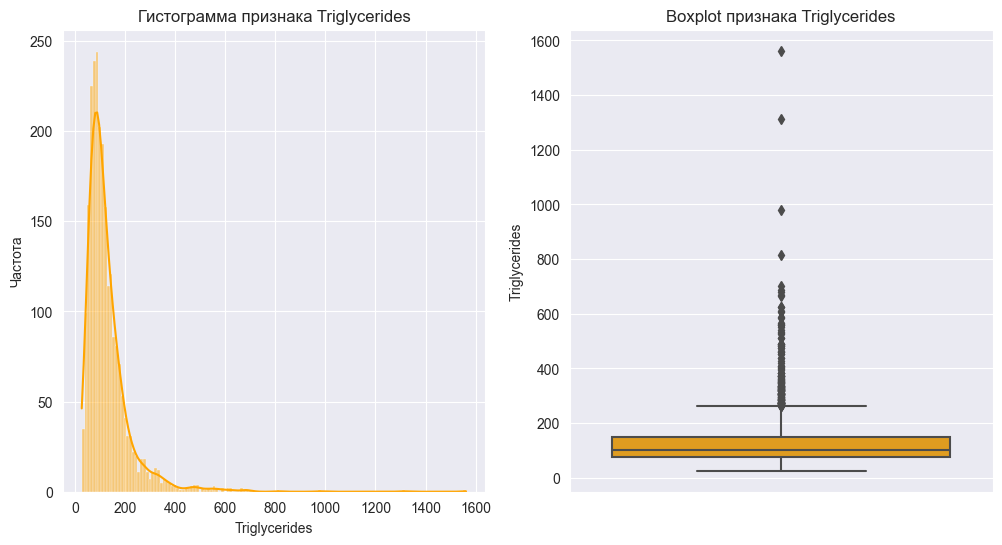

Статистика теста Шапиро–Уилка:  0.6754848957061768
p-значение теста Шапиро–Уилка:  0.0
Отвергаем нулевую гипотезу. Признак Triglycerides, вероятно, НЕ ИМЕЕТ нормальное распределение.


count    2401.000000
mean      128.125364
std        95.322477
min        26.000000
25%        75.000000
50%       103.000000
75%       150.000000
max      1562.000000
Name: Triglycerides, dtype: float64

In [62]:
histplot_boxplot_describe(df['Triglycerides'])

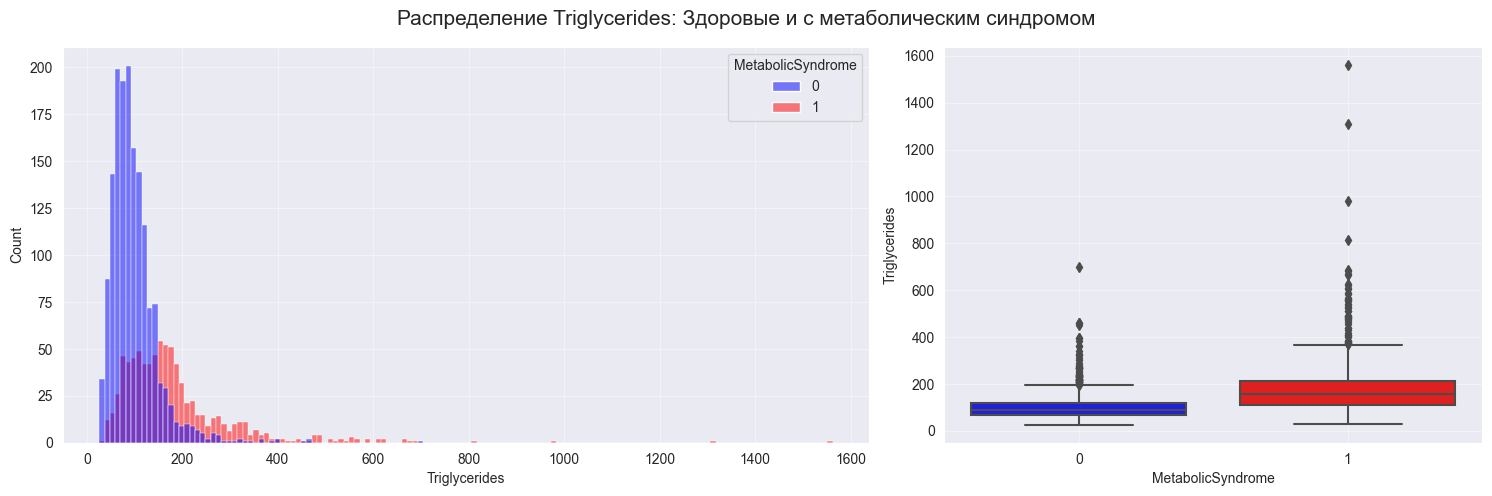

,count,mean,std,min,25%,50%,75%,max
MetabolicSyndrome,,,,,,,,
0,1579.0,98.747308,51.278781,26.0,66.0,89.0,118.00,700.0
1,822.0,184.558394,129.071106,31.0,108.0,157.5,212.75,1562.0


---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О НОРМАЛЬНОСТИ--- 
Здоровые люди:
Статистика теста Шапиро–Уилка:  0.7888739109039307
p-значение теста Шапиро–Уилка:  3.7844867626020335e-41
Признак Triglycerides в группе здоровых людей, вероятно, НЕ ИМЕЕТ нормального распределения.

Люди с метаболическим синдромом:
Статистика теста Шапиро–Уилка:  0.7210176587104797
p-значение теста Шапиро–Уилка:  7.251466233991819e-35
Признак Triglycerides в группе с метаболическим синдромом, вероятно, НЕ ИМЕЕТ нормального распределения.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О РАВЕНСТВЕ ДИСПЕРСИЙ--- 
Статистика теста Левена: 210.2871277127915
p-значение теста Левена: 9.660328789305505e-46
Дисперсии Triglycerides между группами здоровых и с метаболическим синдромом, вероятно, НЕОДНОРОДНЫ.

---ПРОВЕРКА ПРЕДПОЛОЖЕНИЯ О ЗАВИСИМОСТИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ--- 
Статистика теста Манна-Уитни:  268867.5
p-значение теста Манна-Уитни:  5.85354378654075e-123
Отвергаем нулевую гипотезу. Веротяно, существует статистически значимая разница в Triglyceride

In [63]:
tests_for_groups(df['Triglycerides'])

In [64]:
correlations(df['MetabolicSyndrome'], df['Triglycerides'])

Корреляция Пирсона: 0.42724141914562597
Отвергаем нулевую гипотезу для корреляции Пирсона. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Спирмена: 0.4813726658245919
Отвергаем нулевую гипотезу для корреляции Спирмена. Вероятно, корреляция статистически ЗНАЧИМА.

Корреляция Кендалла: 0.3942288491625765
Отвергаем нулевую гипотезу для корреляции Кендалла. Вероятно, корреляция статистически ЗНАЧИМА.


Исходя из данных, заметно, что у людей с синдромом уровень триглицеридов в крови выше, чем у людей без синдрома.
Также заметны многие выбросы, как у людей без синдрома, так и у которых он имеется.

## MetabolicSyndrome

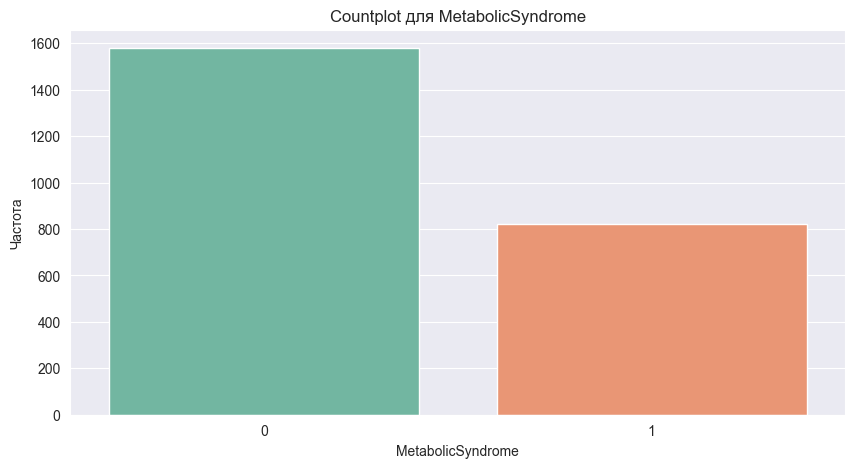

count    2401.000000
mean        0.342357
std         0.474597
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: MetabolicSyndrome, dtype: float64

In [65]:
catplot_describe(df['MetabolicSyndrome'])

In [66]:
counts_metabolic = df['MetabolicSyndrome'].value_counts()
counts_metabolic

MetabolicSyndrome
0    1579
1     822
Name: count, dtype: int64

У целевого признака заметный дисбаланс классов.

## Взаимосвязь признаков

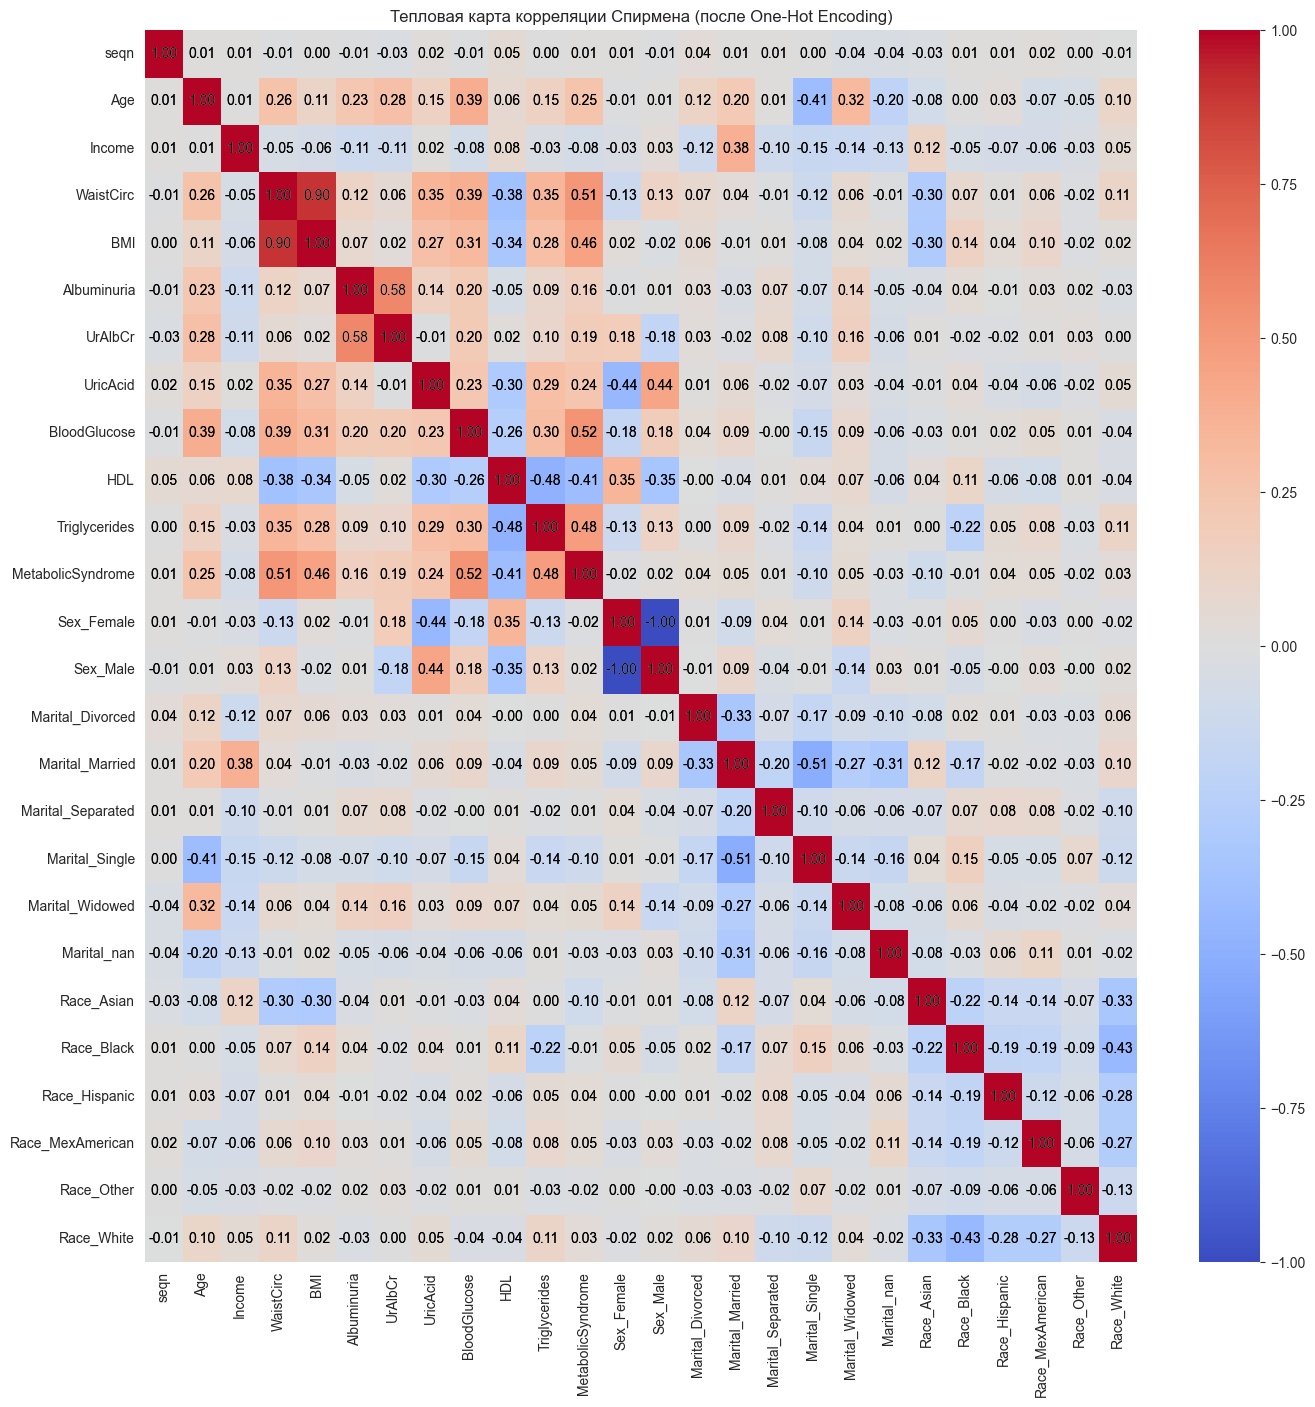

In [67]:
df_encoded = pd.get_dummies(df)
corr_matrix = df_encoded.corr(method='spearman')
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j+0.5, i+0.5, '{:.2f}'.format(corr_matrix.iloc[i, j]), ha='center', va='center', color='black')

plt.title('Тепловая карта корреляции Спирмена (после One-Hot Encoding)')
plt.show()

Из матрицы корреляций, можно сделать вывод, что в данных есть мультиколлинеарность признаков.

Также интересным являтся то, что Sex_Male и Sex_Female коррелируют с WaistCirc, UrAlbCr, BloodGlucose, HDL, UricAcid, Triglycerides.

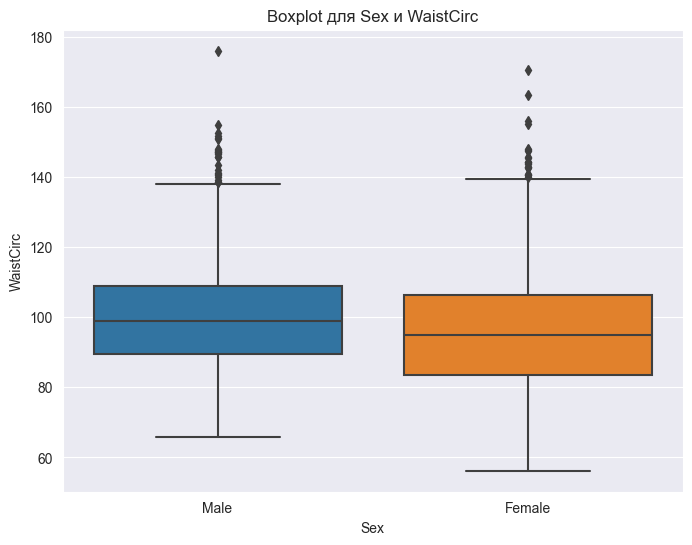

In [68]:
boxplot_cat(df['Sex'], df['WaistCirc'])

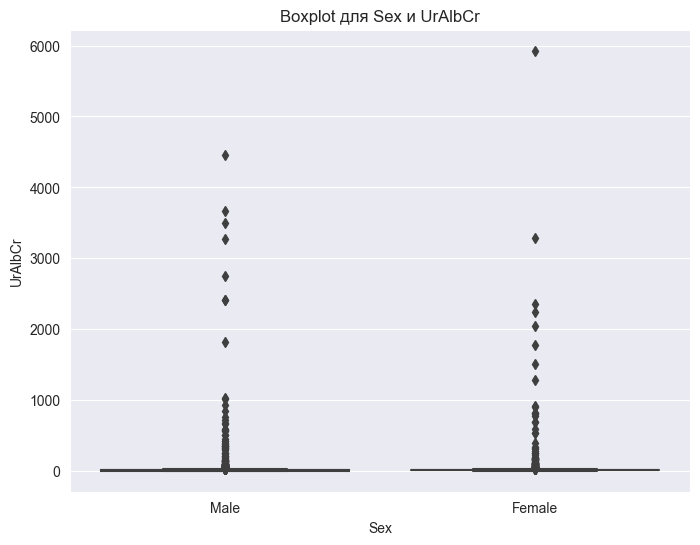

In [69]:
boxplot_cat(df['Sex'], df['UrAlbCr'])

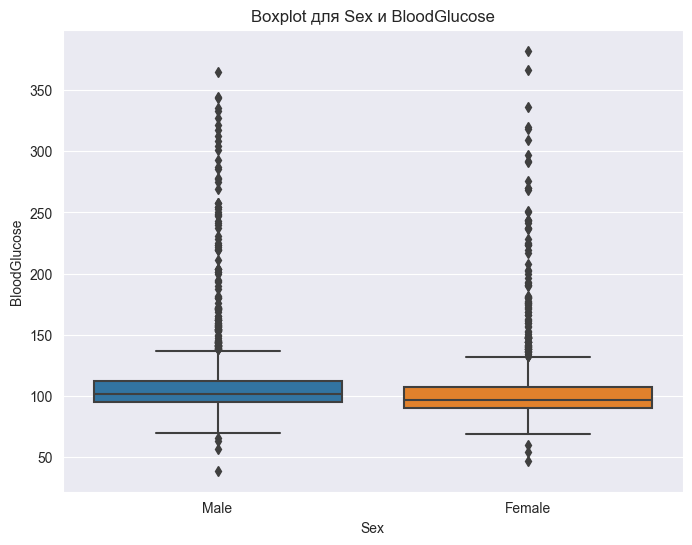

In [70]:
boxplot_cat(df['Sex'], df['BloodGlucose'])

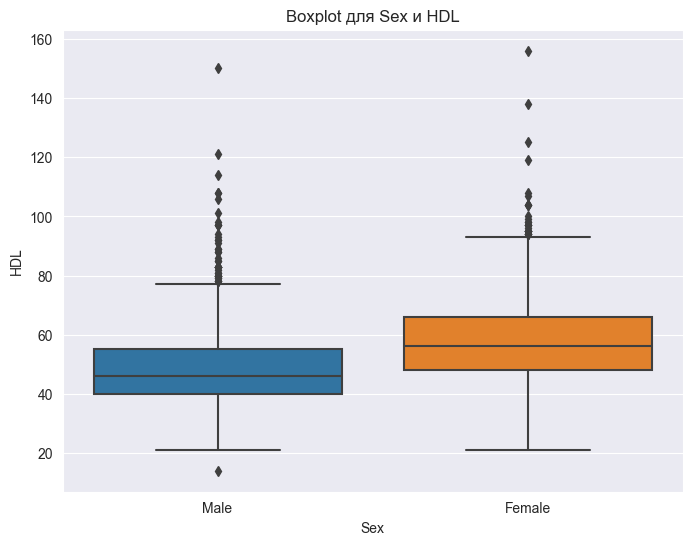

In [71]:
boxplot_cat(df['Sex'], df['HDL'])

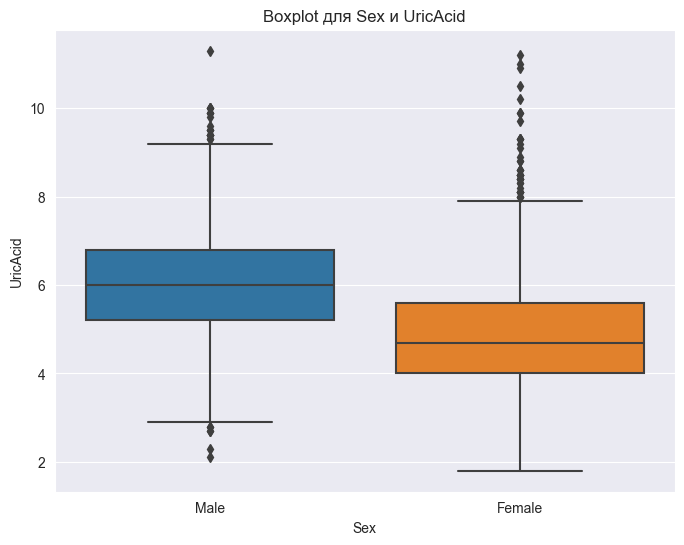

In [72]:
boxplot_cat(df['Sex'], df['UricAcid'])

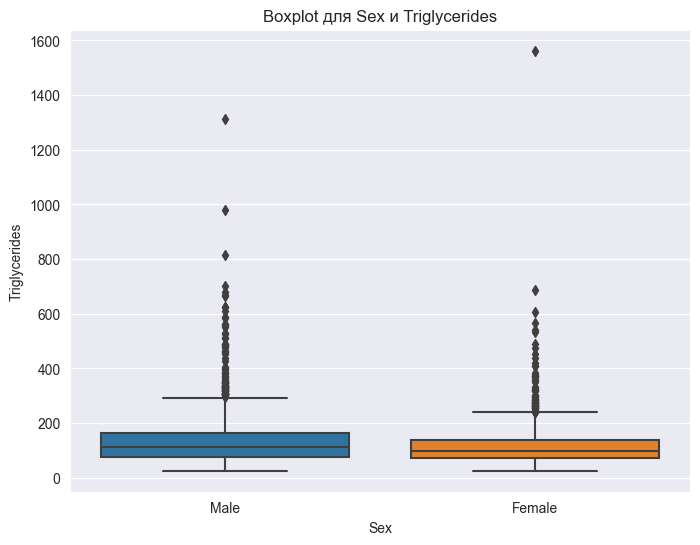

In [73]:
boxplot_cat(df['Sex'], df['Triglycerides'])

Из данных графиков, заметно, что для мужчин и женщин показатели в среднем различаются. Поэтому хоть Sex и MetabolicSyndrome не имеют статистически значимую ассоциацию, возможно, признак Sex в сочетании с другими признаками сыграет важную роль в предсказании целевой переменной.

## Выводы

Размерность датасета:

2401 запись
15 признаков

Типы данных:

Количественные: 11
seqn (int64): Порядковый идентификационный номер              
Age (int64): Возраст человека                
Income (float64): Уровень дохода или информация о доходах          
WaistCirc (float64): Измерение обхвата талии        
BMI: Индекс массы тела           
Albuminuria (int64): Измерение, связанное с содержанием альбумина в моче      
UrAlbCr (float64): Соотношение альбумина и креатинина в моче           
UricAcid (float64): Уровень мочевой кислоты в крови         
BloodGlucose (int64): Уровень глюкозы в крови - показатель риска развития диабета    
HDL (int64): Уровень холестерина липопротеинов высокой плотности ("хорошего" холестерина)                
Triglycerides (int64): Уровень триглицеридов в крови     

Категориальные: 3
Sex (object): Пол человека                
Marital (object): Семейное положение человека       
Race (object): Этническое или расовое происхождение человека

Целевая переменная - бинарная (0: отсутствие метоболического синдрома; 1: наличие метоболического синдрома)

Дубликатов не найдено

Пропсуки в столбцах:

Marital:               208
Income:                117
WaistCirc:              85
BMI:                    26

Признаки, имеющие статистически значимаю корреляцию с целевым признаком:
BloodGlucose(0.52)
WaistCirc(0.50)
BMI(0.50)
Triglycerides(0.48)
HDL(-0.41)
Age(0.25)
UricAcid(0.23)
UrAlbCr(0.19)
Albuminuria(0.15)
Income(-0.07)

Признаки, не имеющие статистически значимаю корреляцию с целевым признаком:
seqn(0.01)

Наличие статистической связи между категориальными переменными с целевой:
Marital(Divorced 0.37; Married 0.16; Separated 0.59; Single 0.26; Widowed 0.45; nan 0.40)
Race(Asian 0.29; Black 0.23; Hispanic 0.34; MexAmerican 0.34; Other 0.70; White 0.18)

Отсутствие статистической связи между категориальными переменными с целевой:
Sex(Female 0.02; Male 0.02)

У целевого признака заметный дисбаланс классов.

# ML

In [74]:
X = df.copy()

X = X.drop(columns=['seqn'])

cat_features = X.select_dtypes(include=['object']).columns.tolist()
X[cat_features] = X[cat_features].fillna('NaN')

X_train, X_test, y_train, y_test = train_test_split(X.drop(['MetabolicSyndrome'], axis=1),
                                                    X['MetabolicSyndrome'], stratify=X['MetabolicSyndrome'],
                                                    test_size=0.2, random_state=42)

In [75]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)

model = CatBoostClassifier(
    random_seed=42,
    task_type='GPU',
    devices='0'
)

model.fit(train_pool)

Learning rate set to 0.032523
0:	learn: 0.6496278	total: 80.5ms	remaining: 1m 20s
1:	learn: 0.6057601	total: 120ms	remaining: 1m
2:	learn: 0.5714440	total: 160ms	remaining: 53.3s
3:	learn: 0.5453548	total: 198ms	remaining: 49.3s
4:	learn: 0.5183339	total: 235ms	remaining: 46.9s
5:	learn: 0.4943827	total: 272ms	remaining: 45.1s
6:	learn: 0.4742469	total: 311ms	remaining: 44.1s
7:	learn: 0.4494788	total: 350ms	remaining: 43.4s
8:	learn: 0.4317485	total: 389ms	remaining: 42.9s
9:	learn: 0.4150003	total: 427ms	remaining: 42.3s
10:	learn: 0.4038079	total: 465ms	remaining: 41.8s
11:	learn: 0.3872055	total: 511ms	remaining: 42.1s
12:	learn: 0.3747686	total: 559ms	remaining: 42.4s
13:	learn: 0.3632187	total: 600ms	remaining: 42.3s
14:	learn: 0.3500868	total: 638ms	remaining: 41.9s
15:	learn: 0.3382502	total: 675ms	remaining: 41.5s
16:	learn: 0.3300099	total: 714ms	remaining: 41.3s
17:	learn: 0.3169964	total: 756ms	remaining: 41.2s
18:	learn: 0.3088889	total: 794ms	remaining: 41s
19:	learn: 0.3

In [76]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [77]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc_score = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nF1 Score:", f1)
print("\nAUC-ROC Score:", auc_score)

Accuracy: 0.9022869022869023

Precision: 0.8641975308641975

Recall: 0.8484848484848485

F1 Score: 0.9020694954090894

AUC-ROC Score: 0.975047947832758


In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       316
           1       0.86      0.85      0.86       165

    accuracy                           0.90       481
   macro avg       0.89      0.89      0.89       481
weighted avg       0.90      0.90      0.90       481


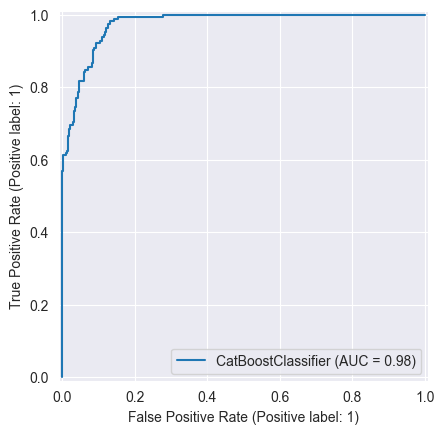

In [79]:
RocCurveDisplay.from_estimator(model, X_test, y_test)

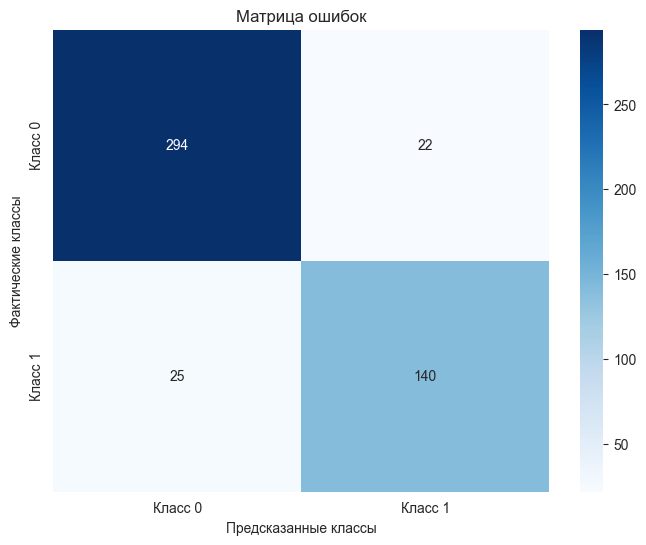

In [80]:
classes = ['Класс 0', 'Класс 1']
plot_confusion_matrix(y_test, y_pred, classes)

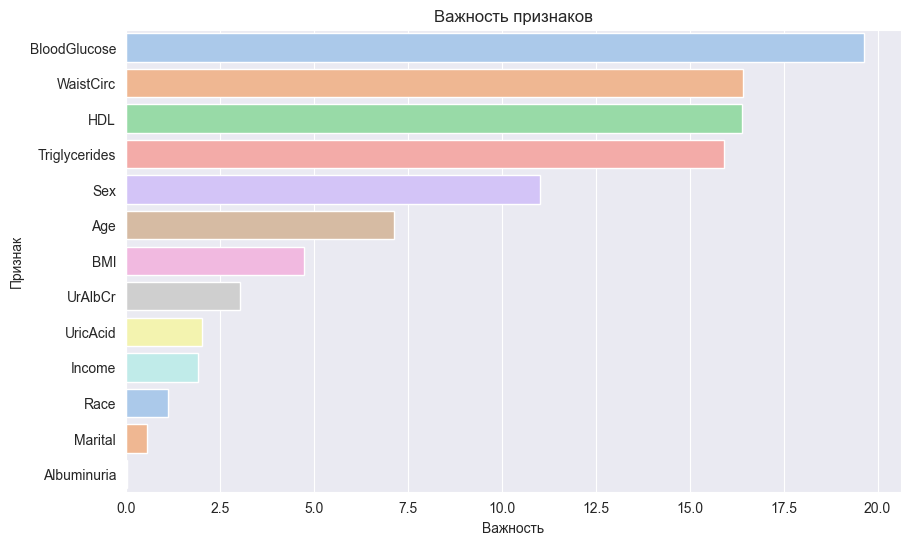

In [81]:
feature_importances = model.feature_importances_
feature_importances_df = pd.DataFrame({'features': list(X_test.columns),
                                       'feature_importances': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='feature_importances', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='feature_importances', y='features', data=feature_importances_df, palette='pastel')
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

In [82]:
feature_importances = model.feature_importances_
feature_importances_df = pd.DataFrame({'Признак': list(X_test),
                                       'Важность признака': feature_importances})
feature_importances_df.sort_values('Важность признака', ascending=False)

,Признак,Важность признака
10,BloodGlucose,19.634412
5,WaistCirc,16.427628
11,HDL,16.380494
12,Triglycerides,15.910009
1,Sex,11.030386
0,Age,7.140908
6,BMI,4.749841
8,UrAlbCr,3.042103
9,UricAcid,2.017760
3,Income,1.920523
